## This script will load the processed GHD anomaly data from step01, and conduct various climate analyses with the CRU 3.21 20th century gridded climate data (monthly temp and precip).

## CRU Datasets are accessible here:
http://www.cru.uea.ac.uk/cru/data/hrg/
    
* Season of analysis: May-June-July (MJJ)
* Years of analysis: 1901-1980

## Tasks
* Load in the CRU climate grids and calculate appropriate seasonal average.
* Calculate regional average time series for the site level, GHD-Core, and GHD-All regressions.
* Conduct regressions and correlation analyses.

## Setup
* Clear the workspace
* Load modules.
* Define function for plotting regional averaging rectangle on the maps.

In [1]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from IPython.display import display
from mpl_toolkits.basemap import Basemap, cm
#sns.set(palette="Set5")

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)

## Set some various user variables. 
* This includes a flag to save output for Lizzie's quality analyses, the months and years I want to analyze (plus associated text marker), and the names of the individual GHD series I will investigate.
* This cell will also load GHD anomaly data for all sites and the associated lat/lon locations.

In [2]:
# Flag for saving output for Lizzie (default=0, no)
lizzie_out_flag = 1;

# User Set Variables (knobs)
# Months to average (climate data)
mons_ave = [5,6,7];     mons_ave_txt = 'MJJ';
yr1 = np.array([1901]); yr2 = np.array([1980])  

# Rectangle Boundaries (Also the region over which I will spatially average the CRU data)
lonmin=-2; lonmax=8; latmin=43; latmax=51;

# Cru Lat/Lon Range (boundaries for the Map)
lat1_cru = np.array([27]);   lat2_cru = np.array([71])   
lon1_cru = np.array([-12]);  lon2_cru = np.array([45])  

# GHD Data: All Sites I want to Analyze
ghd_all_names=[ 'GHDmean',\
                'GHDcore',\
                'Als',\
                'Bor',\
                'Bur',\
                'Cha2',\
                'Lan',\
                'LLV',\
                'SRv',\
                'Swi',\
            ]

# Load formatted GHD anomaly data into a dataframe
infile= '../data/ghd_anom_doy_v02.csv'   # Name of the original data file
df=pd.read_csv(infile)

# Pull out the year vector
yr = np.int64(df.Year)

# Load lat/lon data for individual Sites
infile = '../data/site_locs.csv'   # Name of the data file
df_sitelocs=pd.read_csv(infile)
df_sitelocs.index=df_sitelocs.Location

##  Load and seasonally average/sum the CRU temperature and precipitation data. 
* As part of this, I am creating month and year vectors so that I can pull the specific data I want. This is a more or less global dataset, so I also trim the latitude and longitude ranges for just Europe, where the GHD data is located.

In [3]:
# Create vectors for years and months
mon_cru = np.arange(1,13); mon_all = np.transpose(np.tile(mon_cru,(1,112)))
yr_cru  = np.arange(1901,2013); yr_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Open and Load Data from a NetCDF File
ncfile_tmp = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/cru321/cru_ts3.21.1901.2012.tmp.dat.nc')
ncfile_pre = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/cru321/cru_ts3.21.1901.2012.pre.dat.nc')

# Load in the dimension variables
lon = ncfile_tmp.variables['lon'][:]
lat = ncfile_tmp.variables['lat'][:]

# Just load region I want to look at
# Yr/Lat/Lon Location for Grid Cell I want
i_lat = np.where((lat>=lat1_cru) & (lat<=lat2_cru)); i_lat=i_lat[0]
i_lon = np.where((lon>=lon1_cru) & (lon<=lon2_cru)); i_lon=i_lon[0]

# Initialize Matrices for Climate Variables
tmp_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))
pre_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))

# Load this region for the months requested
for i in enumerate(mons_ave):
    # Location for all instances of the current month    
    loc_mon = np.where(mon_all==i[1]); loc_mon=loc_mon[0];

    # These files are organized: time, lat, lon
    tmp=ncfile_tmp.variables['tmp'][loc_mon,i_lat,i_lon];
    pre=ncfile_pre.variables['pre'][loc_mon,i_lat,i_lon];

    # Store the Monthly Data
    tmp_month[i[0],:,:,:] = tmp
    pre_month[i[0],:,:,:] = pre    
    
    print(i)

# Now calculate seasonal average/sum
tmp_seas_ave = np.nanmean(tmp_month,axis=0)
pre_seas_sum = np.nansum(pre_month,axis=0)

(0, 5)
(1, 6)
(2, 7)


## As the previous cell, but here I load the PDSI data, calculated from the CRU climate grids by Gerard van der Schrier. 
* The files are in a bit of a different format, so this had to be its' own code.

In [4]:
# Create vectors for years and months
mon_cru = np.arange(1,13);      mon_all = np.transpose(np.tile(mon_cru,(1,112)))
yr_cru  = np.arange(1901,2013); yr_all  = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# PDSI data
root_dir = '/Users/bcook/Documents/GEODATA/cru321/'

# CRU PDSI are split up among different files, so I will have to load each one
# individually
files_crupdsi = ['pdsi.3.21.penman.snow.1901-1910.nc', \
    'pdsi.3.21.penman.snow.1911-1920.nc',\
    'pdsi.3.21.penman.snow.1911-1920.nc',\
    'pdsi.3.21.penman.snow.1931-1940.nc',\
    'pdsi.3.21.penman.snow.1941-1950.nc',\
    'pdsi.3.21.penman.snow.1951-1960.nc',\
    'pdsi.3.21.penman.snow.1961-1970.nc',\
    'pdsi.3.21.penman.snow.1971-1980.nc',\
    'pdsi.3.21.penman.snow.1981-1990.nc',\
    'pdsi.3.21.penman.snow.1991-2000.nc',\
    'pdsi.3.21.penman.snow.2001-2010.nc',\
    'pdsi.3.21.penman.snow.2011-2012.nc'\
    ]

# Load in the dimension variables
fname = root_dir+files_crupdsi[0]
ncfile_pdsi = netCDF4.Dataset(fname)
lon = ncfile_pdsi.variables['lon'][:]
lat = ncfile_pdsi.variables['lat'][:]
ncfile_pdsi.close

# Trim lons/lats
i_lat = np.where((lat>=lat1_cru) & (lat<=lat2_cru)); i_lat=i_lat[0]
i_lon = np.where((lon>=lon1_cru) & (lon<=lon2_cru)); i_lon=i_lon[0]
lon_map = lon[i_lon]; lat_map = lat[i_lat];

# Load Each file separately
for ifile in np.arange(0,np.size(files_crupdsi)):
    
    # Current File Name/Open netcdf object
    fname = root_dir+files_crupdsi[ifile]; print(fname)
    ncfile_pdsi = netCDF4.Dataset(fname)
    pdsi = np.float64(ncfile_pdsi.variables['pdsi'][:,i_lat,i_lon]);

    # Concatenate into a complete array for all files
    if ifile==0:
        pdsi_all=pdsi;
    else:
        pdsi_all=np.concatenate((pdsi_all,pdsi),axis=0)

    # Close netcdf file
    ncfile_pdsi.close

# Now pull out and calculate seasonal averages
# Initialize Matrices for Climate Variables
pdsi_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))

# Load this region for the months requested
for i in enumerate(mons_ave):
    print(i)
    # Location for all instances of the current month    
    loc_mon = np.where(mon_all==i[1]); loc_mon=loc_mon[0];

    # Store in a new matrix
    pdsi_month[i[0],:,:,:] = pdsi_all[loc_mon,:,:]

# Seasonal average PDSI
pdsi_seas = np.nanmean(pdsi_month,axis=0)

# Delete Variables I don't need anymore
del(pdsi_month)
del(pdsi_all)
del(pdsi)

/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1901-1910.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1911-1920.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1911-1920.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1931-1940.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1941-1950.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1951-1960.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1961-1970.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1971-1980.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1981-1990.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1991-2000.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.2001-2010.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.2011-2012.nc
(0, 5)
(1, 6)
(2, 7)


* All the data should now be loaded. This cell just does a quick check to make sure the format of the climate data looks okay.

In [5]:
# All the data should now be loaded by this point
# Location (indices) of Years to Correlate
# 
print('All the climate data is now loaded, and averaged to create the seasonal average/sums.')
print('They should be arrayed as: yr x lat x lon ')
print('')
print('Yrs: '+np.str(np.min(yr_cru))+'-'+np.str(np.max(yr_cru)))
print('Lat: '+np.str(np.min(lat_map))+' to '+np.str(np.max(lat_map)))
print('Lon: '+np.str(np.min(lon_map))+' to '+np.str(np.max(lon_map)))
print('')
print('Temp Array Size: '+np.str(tmp_seas_ave.shape))
print('Prec Array Size: '+np.str(pre_seas_sum.shape))
print('PDSI Array Size: '+np.str(pdsi_seas.shape))


All the climate data is now loaded, and averaged to create the seasonal average/sums.
They should be arrayed as: yr x lat x lon 

Yrs: 1901-2012
Lat: 27.25 to 70.75
Lon: -11.75 to 44.75

Temp Array Size: (112, 88, 114)
Prec Array Size: (112, 88, 114)
PDSI Array Size: (112, 88, 114)


* For the regression analyses, I need time series. This next cell will calculate regional average time series (cosine area weighted by latitude) from the CRU data. For the GHD-Core and GHD-All comparison, I pick a big area that encompasses most of France. For individual GHD series, I average data within 1 deg (all directions) of the site location.

In [6]:
# Calculate Regional Averages for CRU Data around each of the GHD Locations. For the Core and Composite Indices,
# use a large region covering France.

# Arrays to store regional average PDSI/Temp/Precip for each site
pdsi_coswtmean = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))
tmp_coswtmean  = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))
pre_coswtmean  = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))

# +/- degrees to average climate around each site
#    I use one degree in every direction because the scPDSI data is missing from some coastal regions.
#    Regardless, this is still within the typical correlation decay distance for these variables,
#    and it should be fine.
deg_range = 1; range_txt = 'onedeg';

# Loop through each site individually.
for ifile in enumerate(ghd_all_names):
    # Counter
    print(ifile)
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        
        # Latitude/Longitude range for averaging
        print("lat range = ("+np.str(latmin)+" to "+np.str(latmax)+")")
        print("lon range = ("+np.str(lonmin)+" to "+np.str(lonmax)+")")
       
        i_lat_reg = np.where((lat_map>=latmin) & (lat_map<=latmax)); i_lat_reg=i_lat_reg[0]
        i_lon_reg = np.where((lon_map>=lonmin) & (lon_map<=lonmax)); i_lon_reg=i_lon_reg[0]

        # Latitude and Longitude Indices for this region
        lon_reg = lon_map[i_lon_reg]
        lat_reg = lat_map[i_lat_reg]

        # Create Latitude Weights
        lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
        lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
        lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        
        # Region to average over will be +/- 1 degree around the center location
        latmin_new = lat_site-deg_range; latmax_new = lat_site+deg_range;
        lonmin_new = lon_site-deg_range; lonmax_new = lon_site+deg_range;
 
        # Latitude/Longitude range for averaging
        print("lat range = ("+np.str(latmin_new)+" to "+np.str(latmax_new)+")")
        print("lon range = ("+np.str(lonmin_new)+" to "+np.str(lonmax_new)+")")
        
        # Locations of these grid cells
        i_lat_reg = np.where((lat_map>=latmin_new) & (lat_map<=latmax_new)); i_lat_reg=i_lat_reg[0]
        i_lon_reg = np.where((lon_map>=lonmin_new) & (lon_map<=lonmax_new)); i_lon_reg=i_lon_reg[0]
        
        # Latitude and Longitude Indices for this region
        lon_reg = lon_map[i_lon_reg]
        lat_reg = lat_map[i_lat_reg]
        
        # Create Latitude Weights
        lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
        lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
        lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)
        
    # Load Each Year and Spatially Average
    for i_yr in enumerate(yr_cru):
        #print(i_yr)
        # Pull out Current Month Temp/Precip
        pdsi_curr = pdsi_seas[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        temp_curr = tmp_seas_ave[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        prec_curr = pre_seas_sum[i_yr[0],i_lat_reg,:][:,i_lon_reg]

        # Mask ocean cells
        prec_curr[prec_curr>=100000]=np.nan
        temp_curr[temp_curr>=100000]=np.nan
        pdsi_curr[pdsi_curr>=100000]=np.nan
        
        # Cosine Weighted Average
        pdsi_coswtmean[i_yr[0],ifile[0]] = np.ma.average(np.ma.masked_invalid(pdsi_curr),weights=lat_wts_grid)
        tmp_coswtmean[i_yr[0],ifile[0]]  = np.ma.average(np.ma.masked_invalid(temp_curr),weights=lat_wts_grid)
        pre_coswtmean[i_yr[0],ifile[0]]  = np.ma.average(np.ma.masked_invalid(prec_curr),weights=lat_wts_grid)


(0, 'GHDmean')
lat range = (43 to 51)
lon range = (-2 to 8)
(1, 'GHDcore')
lat range = (43 to 51)
lon range = (-2 to 8)
(2, 'Als')
lat range = (47.17 to 49.17)
lon range = (6.28 to 8.28)
(3, 'Bor')
lat range = (44.18 to 46.18)
lon range = (-1.75 to 0.25)
(4, 'Bur')
lat range = (46.32 to 48.32)
lon range = (4.04 to 6.04)
(5, 'Cha2')
lat range = (46.98 to 48.98)
lon range = (3.28 to 5.28)
(6, 'Lan')
lat range = (42.6 to 44.6)
lon range = (2.87 to 4.87)
(7, 'LLV')
lat range = (46.15 to 48.15)
lon range = (-0.78 to 1.22)
(8, 'SRv')
lat range = (42.98 to 44.98)
lon range = (4.05 to 6.05)
(9, 'Swi')
lat range = (45.57 to 47.57)
lon range = (5.52 to 7.52)


* Here is just some debugging to make sure I got the regional averaging correct. I take the individual regional CRU climate time series, and conduct point-by-point correlations (Spearman's rank) against the same variables (temp vs temp, prec vs prec. pdsi vs pdsi). O
* Because this is just for debugging purposes, I am not going to worry about detrending or anything like that.

In [7]:
# Initialize Matrices for Correlation Results
rho_temp_vs_temp_reg  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); 
rho_temp_vs_temp_reg[:]=np.NAN

rho_prec_vs_prec_reg  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); 
rho_prec_vs_prec_reg[:]=np.NAN

rho_pdsi_vs_pdsi_reg  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); 
rho_pdsi_vs_pdsi_reg[:]=np.NAN

# Pull Out All The Sites Names
site_names = df_sitelocs.Location

# Loop through each GHD site individually-------------------------------------------------------------------------------------
#  Starting from 2 makes sure we only loop through the individual sites and not the larger scale regional average.
for ifile in enumerate(ghd_all_names[2:]):
    # Counter
    print(ifile)
    
    # Pull Climate Series for These Sites
    temp_site = np.float64(tmp_coswtmean[:,ifile[0]+2]);  
    prec_site = np.float64(pre_coswtmean[:,ifile[0]+2]);  
    pdsi_site = np.float64(pdsi_coswtmean[:,ifile[0]+2]);  
    
    # Loop through each gridcell of climate data and calculate the correlations---------------------------------------------------
    for n_lat in enumerate(i_lat):
        for n_lon in enumerate(i_lon):
    
            # Pull out Individual gridcell pdsi/temp/prec
            temp_seas_cell = tmp_seas_ave[:,n_lat[0],n_lon[0]]
            prec_seas_cell = pre_seas_sum[:,n_lat[0],n_lon[0]]
            pdsi_seas_cell = pdsi_seas[:,n_lat[0],n_lon[0]]

            # Put in NaN if ocean areas (missing values)
            if temp_seas_cell[0]>1000:

                rho_temp_vs_temp_reg[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                rho_prec_vs_prec_reg[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                rho_pdsi_vs_pdsi_reg[ifile[0],n_lat[0],n_lon[0]]  = np.nan
           
            else:   
                             
                # Spearman rank correlations: Temp
                rho,pval = stats.spearmanr(temp_seas_cell,temp_site)    
                rho_temp_vs_temp_reg[ifile[0],n_lat[0],n_lon[0]]  = rho
             
                # Spearman rank correlations: Precipitation
                rho,pval = stats.spearmanr(prec_seas_cell,prec_site)    
                rho_prec_vs_prec_reg[ifile[0],n_lat[0],n_lon[0]]  = rho

                # Spearman rank correlations: Precipitation
                rho,pval = stats.spearmanr(pdsi_seas_cell,pdsi_site)    
                rho_pdsi_vs_pdsi_reg[ifile[0],n_lat[0],n_lon[0]]  = rho
                

(0, 'Als')
(1, 'Bor')
(2, 'Bur')
(3, 'Cha2')
(4, 'Lan')
(5, 'LLV')
(6, 'SRv')
(7, 'Swi')


* Here, we're just going to set up some parameters for plotting up these debugging figures.

In [8]:
# FIGURE PLOTTING PARAMETERS FOR DEBUGGING

# Set Map Limits and coordinates for mapping
lon_map = lon[i_lon]; lat_map = lat[i_lat];
lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
lon_map, lat_map = np.meshgrid(lon_map, lat_map)

site_color = np.float64([0,0,0])/255

# Title info
fontdict = {'fontsize': 18}

numrow=3
numcol=3
figdims=20


* Here, plot correlations for temperature. NOTE: red here indicates POSITIVE correlation.

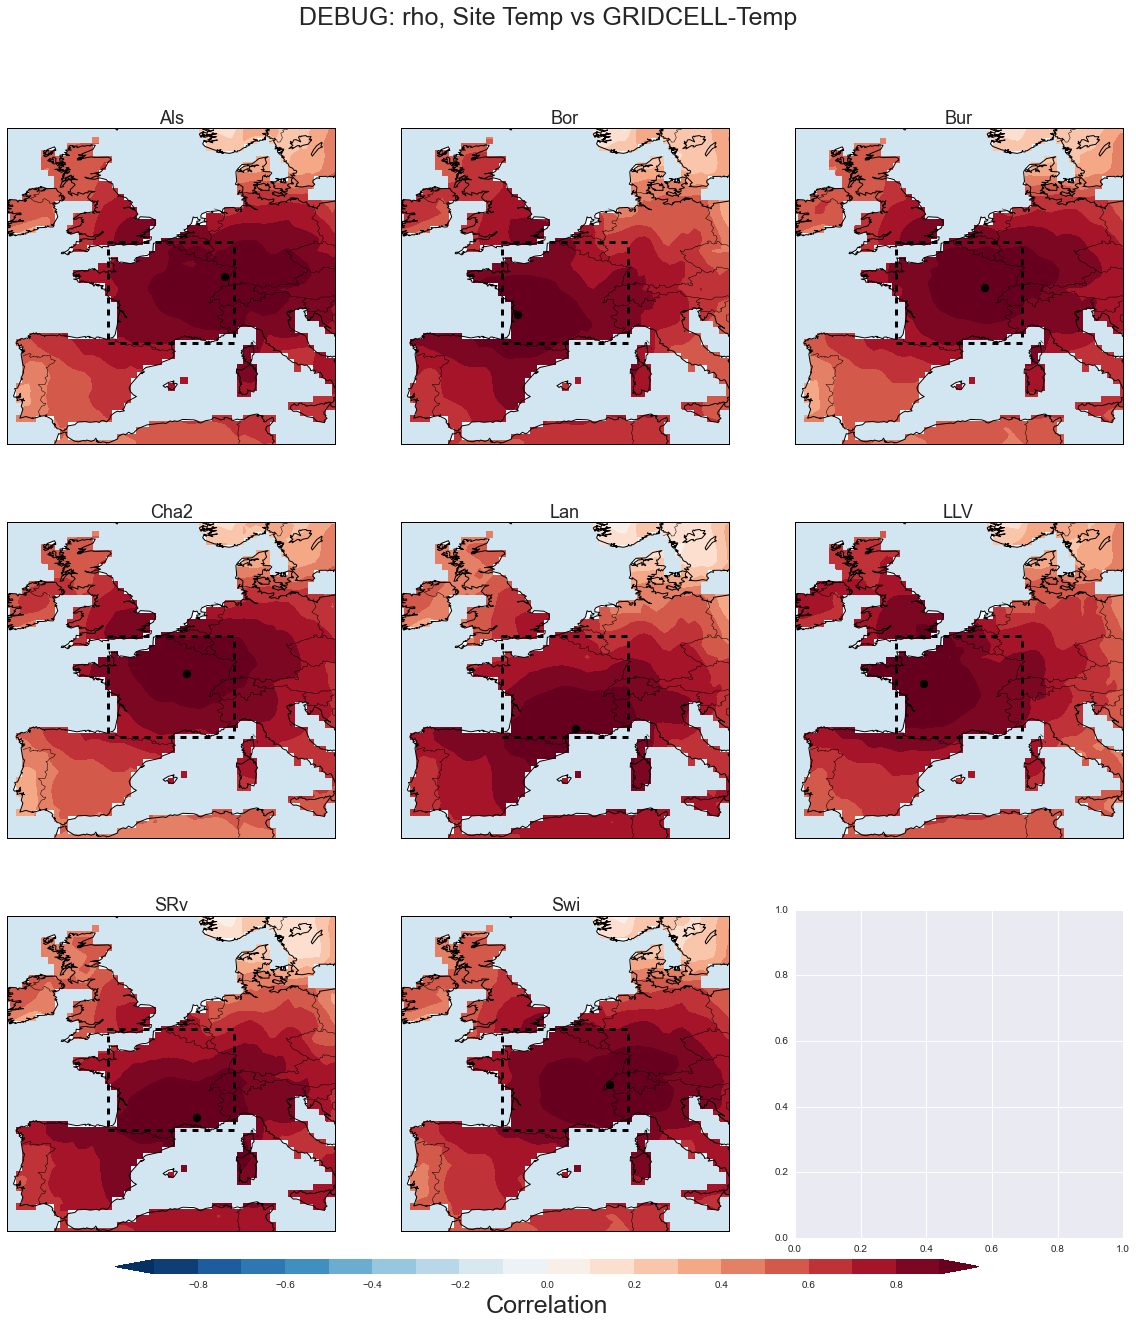

In [9]:
# (1) SETUP FIGURE
title_txt = 'DEBUG: rho, Site Temp vs GRIDCELL-Temp'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names[2:]):

    axcurr = axes.flat[ifile[0]];
    
    # Pull out current correlation field
    corr_field = rho_temp_vs_temp_reg[ifile[0],:,:];

    # Pull out correct lat/lon for this site
    lat_site = df_sitelocs.Latitude[ifile[1]]
    lon_site = df_sitelocs.Longitude[ifile[1]]

    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu_r,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
sns.plt.suptitle(title_txt,fontsize=25)
#out_txt = '../figures/step03/corrmap.ghd.vs.temp.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

* Here, plot correlations for precipitation. NOTE: red here indicates POSITIVE correlation.

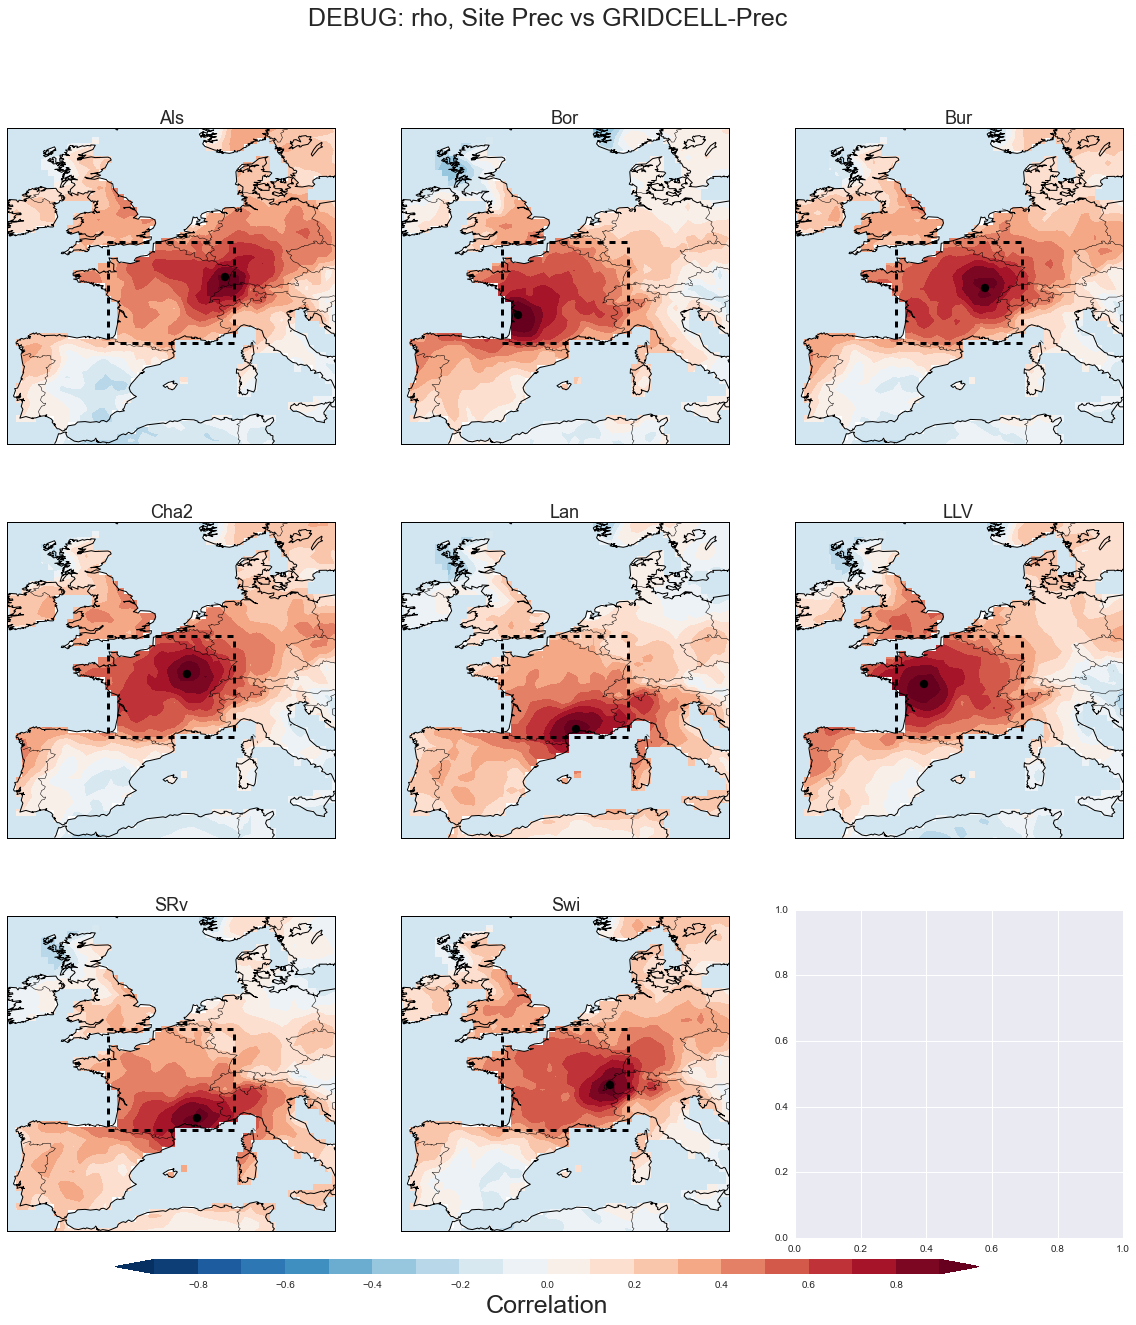

In [10]:
# NOW, PLOT UP THESE CORRELATIONS TO CHECK. PRECIPITATION FIRST.
#   RED = POSITIVE CORRELATION
# (1) SETUP FIGURE
title_txt = 'DEBUG: rho, Site Prec vs GRIDCELL-Prec'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names[2:]):

    axcurr = axes.flat[ifile[0]];
    
    # Pull out current correlation field
    corr_field = rho_prec_vs_prec_reg[ifile[0],:,:];

    # Pull out correct lat/lon for this site
    lat_site = df_sitelocs.Latitude[ifile[1]]
    lon_site = df_sitelocs.Longitude[ifile[1]]

    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu_r,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
sns.plt.suptitle(title_txt,fontsize=25)
#out_txt = '../figures/step03/corrmap.ghd.vs.temp.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

* Here, plot correlations for PDSI. NOTE: red here indicates POSITIVE correlation.

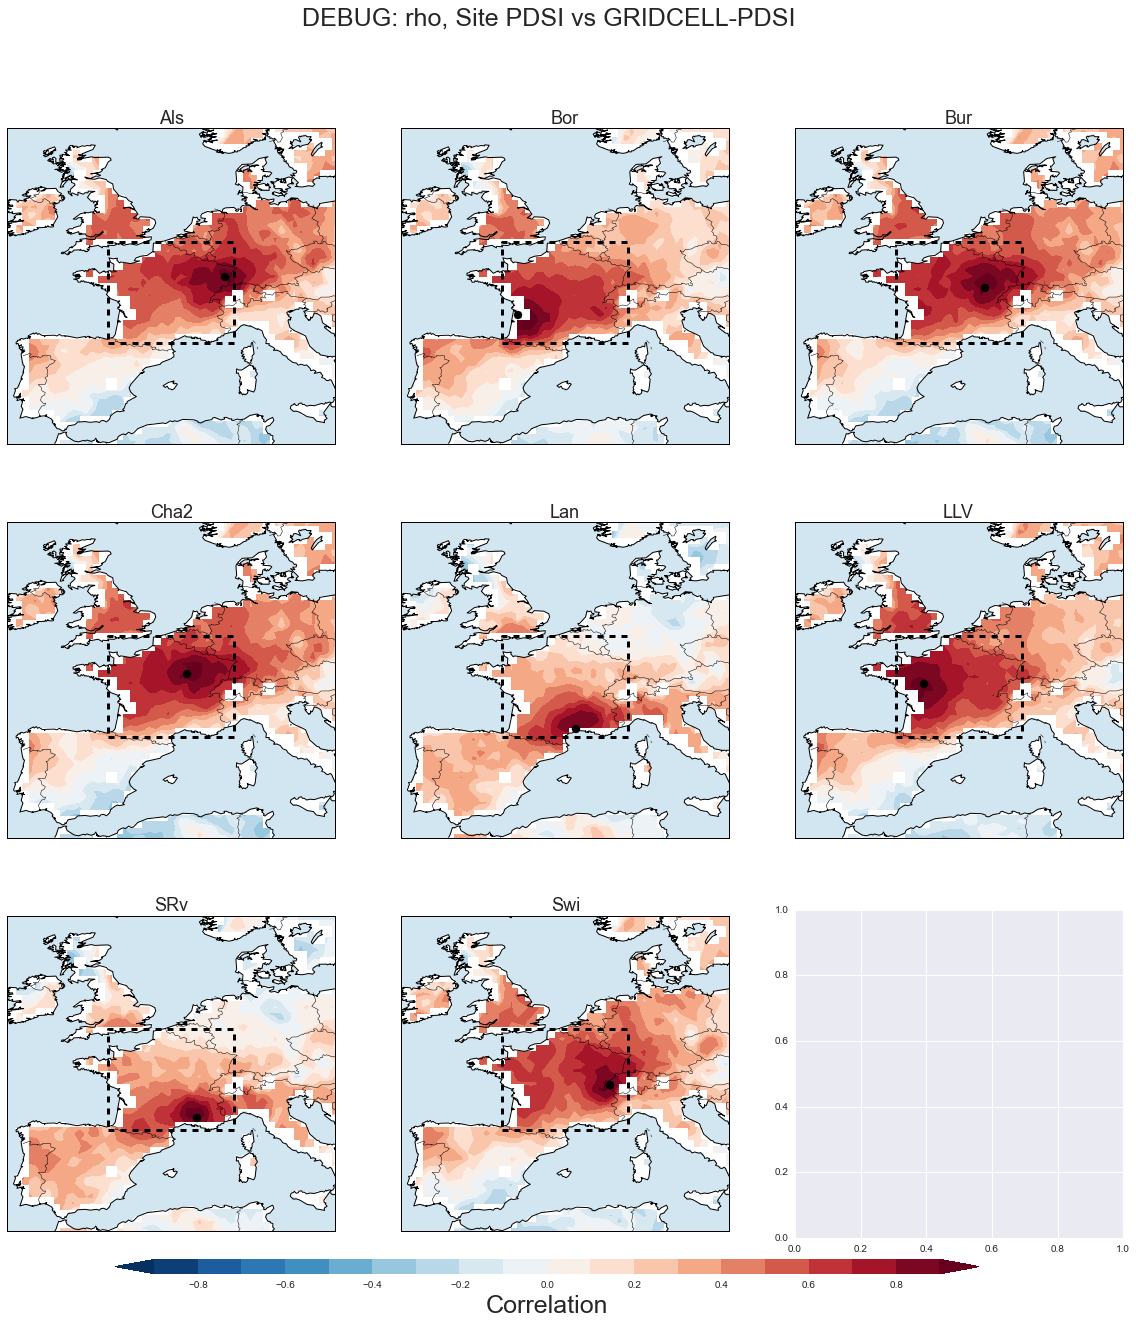

In [11]:
# NOW, PLOT UP THESE CORRELATIONS TO CHECK. PDSI.
#   RED = POSITIVE CORRELATION
# (1) SETUP FIGURE
title_txt = 'DEBUG: rho, Site PDSI vs GRIDCELL-PDSI'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names[2:]):

    axcurr = axes.flat[ifile[0]];
    
    # Pull out current correlation field
    corr_field = rho_pdsi_vs_pdsi_reg[ifile[0],:,:];

    # Pull out correct lat/lon for this site
    lat_site = df_sitelocs.Latitude[ifile[1]]
    lon_site = df_sitelocs.Longitude[ifile[1]]

    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu_r,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
sns.plt.suptitle(title_txt,fontsize=25)
#out_txt = '../figures/step03/corrmap.ghd.vs.temp.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator


* Climate time series check looks good! Now I will save these time series to a csv file for Lizzie so that she can conduct her quality analysis.

In [12]:
if lizzie_out_flag==1:
    # Create Data Frames with Seasonal climate variables (row=years, columns=sitenames)
    df_seas_temp = pd.DataFrame(tmp_coswtmean, index=yr_cru, columns=ghd_all_names)
    df_seas_prec = pd.DataFrame(pre_coswtmean, index=yr_cru, columns=ghd_all_names)
    df_seas_pdsi = pd.DataFrame(pdsi_coswtmean, index=yr_cru, columns=ghd_all_names)

    # Create Output (csv files), and remove (delete) old files
    
    # Temperature
    outfile = '../data/seas_temp_'+mons_ave_txt+'.'+range_txt+'.csv'; 
    if os.path.exists(outfile):
        os.remove(outfile); 
    df_seas_temp.to_csv(outfile,sep=','); print(outfile)
    
    # Precipitation
    outfile = '../data/seas_prec_'+mons_ave_txt+'.'+range_txt+'.csv'; 
    if os.path.exists(outfile):
        os.remove(outfile); 
    df_seas_prec.to_csv(outfile,sep=','); print(outfile)
    
    # PDSI
    outfile = '../data/seas_pdsi_'+mons_ave_txt+'.'+range_txt+'.csv'; 
    if os.path.exists(outfile):
        os.remove(outfile); 
    df_seas_pdsi.to_csv(outfile,sep=','); print(outfile)


../data/seas_temp_MJJ.onedeg.csv
../data/seas_prec_MJJ.onedeg.csv
../data/seas_pdsi_MJJ.onedeg.csv


* No we're ready to do some interesting regression analyses. First, I just need to set up some axes limits for the regression figures to facilitate comparisons across time intervals for GHD-ALL and GHD-Core.

In [13]:
if mons_ave_txt=='MJJ':
    print("MJJ Limits")

    # Limits for MJJ
    limit_ghd=np.float64([-40,20]); 
    limit_temp=np.float64([12,20]); 
    limit_prec=np.float64([80,370]); 
    limit_pdsi=np.float64([-5,4])
 
elif mons_ave_txt=='JJA':
    print("JJA Limits")

    # Limits for JJA
    limit_ghd=np.float64([-35,20]); 
    limit_temp=np.float64([14,22]); 
    limit_prec=np.float64([50,375]); 
    limit_pdsi=np.float64([-5,4]);
    

MJJ Limits


#### Regression Analysis GHD-All and GHD-Core
* These first sets of regressions will be over the interval 1901-1980. The figures will show the results for the NON-DETRENDED data. However, I will store the regression results (slope, R2, p-value) for both the detrended and the non-detrended time series in order to see how much of a difference it actually makes.

(0, 'GHDmean')
(1, 'GHDcore')


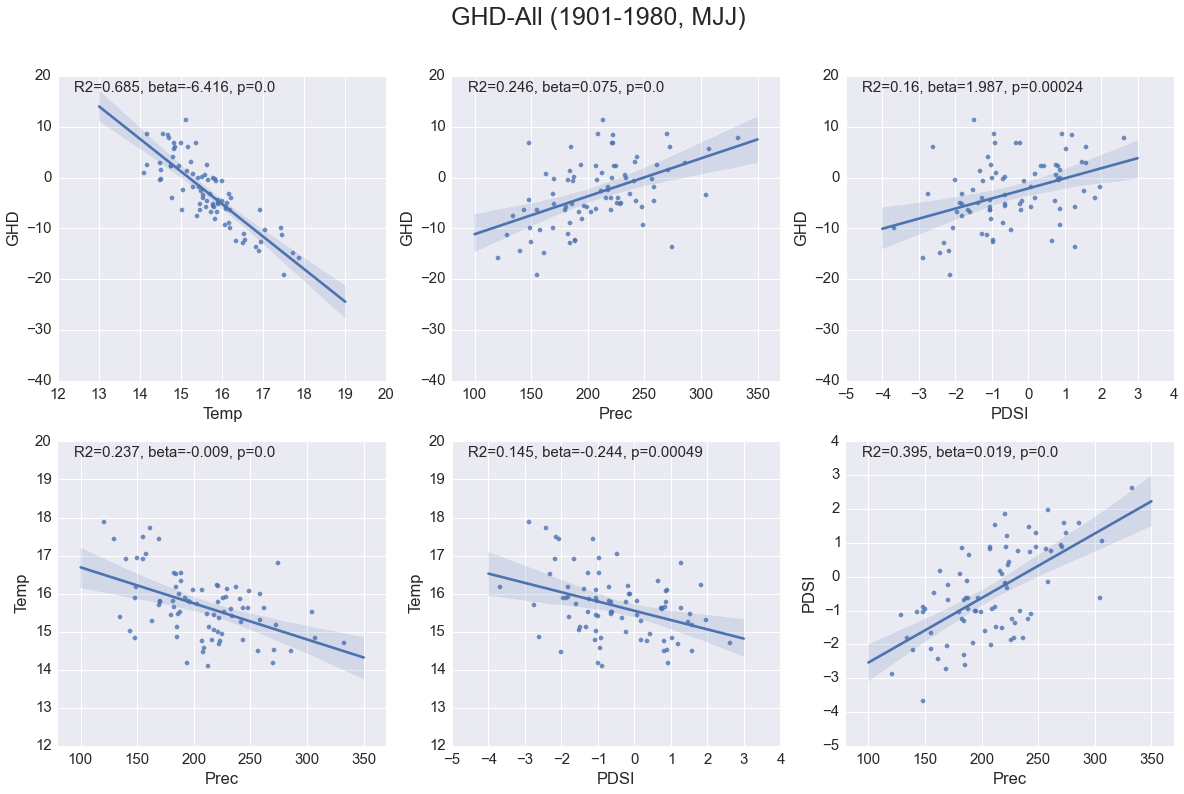

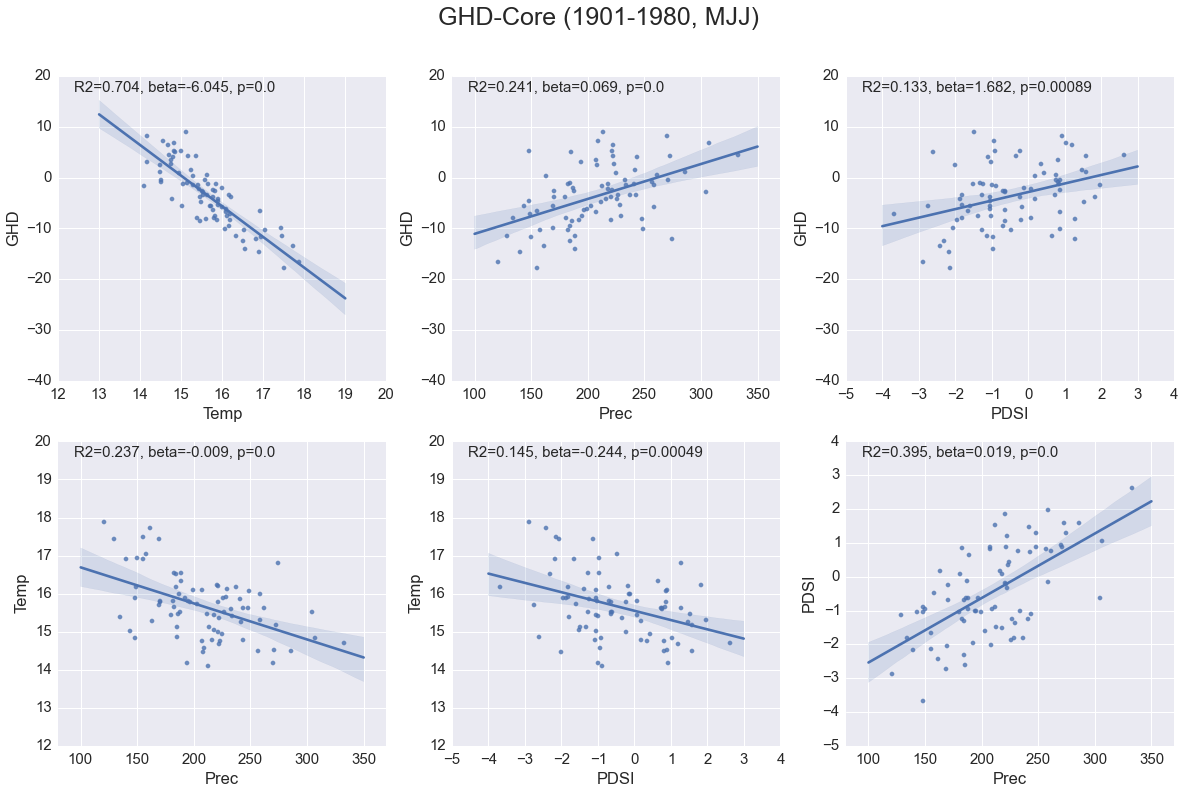

In [15]:
# First, let's do the regressions for GHDcore and GHDmean:  
# Year Locations of the GHD data.
loc_yrs_ghd = np.where((yr>=yr1) & (yr<=yr2))[0];

# Year Locations of the Climate Data.
loc_yrs_cru = np.where((yr_cru>=yr1) & (yr_cru<=yr2))[0];

# Initialize Storage Array for Regression Stats (Slope, R2, pval)
reg_GHDvTemp  = np.zeros((2,6))
reg_GHDvPrec  = np.zeros((2,6))
reg_GHDvPDSI  = np.zeros((2,6))

reg_TempvPrec = np.zeros((2,6))
reg_TempvPDSI = np.zeros((2,6))
reg_PDSIvPrec = np.zeros((2,6))

# Regression and scatter plots each GHD-ALL and GHD-Core
for ifile in enumerate(ghd_all_names[0:2]):

    print(ifile)

    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]]

    # Create Data Frame
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe for regression plots
    df_siteclim.GHD  = np.float64(ghd)
    df_siteclim.Temp = np.float64(tmp_series)
    df_siteclim.Prec = np.float64(pre_series)
    df_siteclim.PDSI = np.float64(pdsi_series)

    # Remove Missing Values (necessary for regression calculation)
    # Not necessary for GHD-ALL and GHD-Core.
    #
    #df_siteclim=df_siteclim[df_siteclim.GHD.notnull()];
    
    # Series Name 
    series_name = ifile[1]

    # Rename Composite Series for the Figures
    if series_name=='GHDmean':
        series_name='GHD-All'
        
    if series_name=='GHDcore':
        series_name='GHD-Core'
        
    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,12])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD------------------------------------------------------------------------------------------
    sns.plt.subplot(2,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_temp)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvTemp[ifile[0],0] = slope; reg_GHDvTemp[ifile[0],2] = R2; reg_GHDvTemp[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Temp),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvTemp[ifile[0],1] = slope; reg_GHDvTemp[ifile[0],3] = R2; reg_GHDvTemp[ifile[0],5] = p_value;
    
    # Subplot #2: Prec vs GHD------------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_prec)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPrec[ifile[0],0] = slope; reg_GHDvPrec[ifile[0],2] = R2; reg_GHDvPrec[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPrec[ifile[0],1] = slope; reg_GHDvPrec[ifile[0],3] = R2; reg_GHDvPrec[ifile[0],5] = p_value;
    
    # Subplot #3: PDSI vs GHD------------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_pdsi)  
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
 
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPDSI[ifile[0],0] = slope; reg_GHDvPDSI[ifile[0],2] = R2; reg_GHDvPDSI[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPDSI[ifile[0],1] = slope; reg_GHDvPDSI[ifile[0],3] = R2; reg_GHDvPDSI[ifile[0],5] = p_value;

    # Subplot #4: Prec vs Temp------------------------------------------------------------------------------------------
    sns.plt.subplot(2,3,4),sns.regplot("Prec","Temp",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_temp)
    sns.plt.xlim(limit_prec) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.Temp)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)     

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_TempvPrec[ifile[0],0] = slope; reg_TempvPrec[ifile[0],2] = R2; reg_TempvPrec[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.Temp))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_TempvPrec[ifile[0],1] = slope; reg_TempvPrec[ifile[0],3] = R2; reg_TempvPrec[ifile[0],5] = p_value;
    
    # Subplot #5: PDSI vs Temp-----------------------------------------------------------------------------------------
    sns.plt.subplot(2,3,5),sns.regplot("PDSI","Temp",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_temp)
    sns.plt.xlim(limit_pdsi) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.Temp)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)        

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_TempvPDSI[ifile[0],0] = slope; reg_TempvPDSI[ifile[0],2] = R2; reg_TempvPDSI[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.Temp))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_TempvPDSI[ifile[0],1] = slope; reg_TempvPDSI[ifile[0],3] = R2; reg_TempvPDSI[ifile[0],5] = p_value;
    
    # Subplot #6: PDSI vs Prec---------------------------------------------------------------------------------------- 
    sns.plt.subplot(2,3,6),sns.regplot("Prec","PDSI",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_pdsi)
    sns.plt.xlim(limit_prec) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.PDSI)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)      
    
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_PDSIvPrec[ifile[0],0] = slope; reg_PDSIvPrec[ifile[0],2] = R2; reg_PDSIvPrec[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.PDSI))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_PDSIvPrec[ifile[0],1] = slope; reg_PDSIvPrec[ifile[0],3] = R2; reg_PDSIvPrec[ifile[0],5] = p_value;
        
    #------------------------------------------------------------------------------------------------------------------
    sns.plt.tight_layout
    #sns.plt.savefig('../figures/step03/'+series_name+'.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
    #                '-'+np.str(yr2[0])+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator   
        
    

* Okay, now we will create some dataframes and look at the regression results for non-detrended and detrended versions of the time series. In all cases, overall results are really quite similar between the detrended and the non-detrended analyses.

In [16]:
print("Regression Analyses Results: Display the slopes, R2, and pvalues for each of the regressions,")
print("with and without linearly detrending the data first")
print("")

# Create Data Frames of Regression Analyses
index_txt = ["GHD-All","GHD-Core"]
col_txt=["beta","beta-D","R2","R2-D","pval","pval-D"]

# GHD versus Temperature
df_reg_GHDvTemp = pd.DataFrame(reg_GHDvTemp, index=index_txt, \
                               columns=col_txt)
print("GHD vs Temperature: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_GHDvTemp)

# GHD versus Precipitation
df_reg_GHDvPrec = pd.DataFrame(reg_GHDvPrec, index=index_txt, \
                               columns=col_txt)
print("GHD vs Precipitation: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_GHDvPrec) 

# GHD versus PDSI
df_reg_GHDvPDSI = pd.DataFrame(reg_GHDvPDSI, index=index_txt, \
                               columns=col_txt)
print("GHD vs PDSI: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_GHDvPDSI) 

print("NOTE: Both GHD-All and GHD-Core use the same CRU climate time series")

# Temp versus Prec
df_reg_TempvPrec = pd.DataFrame(reg_TempvPrec, index=index_txt, \
                               columns=col_txt)
print("Temp vs Prec: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_TempvPrec) 

# Temp versus PDSI
df_reg_TempvPDSI = pd.DataFrame(reg_TempvPDSI, index=index_txt, \
                               columns=col_txt)
print("Temp vs PDSI: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_TempvPDSI) 

# PDSI vs Prec
df_reg_PDSIvPrec = pd.DataFrame(reg_PDSIvPrec, index=index_txt, \
                               columns=col_txt)
print("PDSI vs Prec: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_PDSIvPrec) 


Regression Analyses Results: Display the slopes, R2, and pvalues for each of the regressions,
with and without linearly detrending the data first

GHD vs Temperature: 1901-1980


beta    beta-D     R2   R2-D          pval        pval-D
GHD-All  -6.415992 -6.636558  0.685  0.789  3.078302e-21  4.527829e-28
GHD-Core -6.044534 -6.218814  0.704  0.780  2.583615e-22  2.293206e-27

GHD vs Precipitation: 1901-1980


beta    beta-D     R2   R2-D      pval    pval-D
GHD-All   0.074725  0.074312  0.246  0.263  0.000003  0.000001
GHD-Core  0.068827  0.068518  0.241  0.252  0.000004  0.000002

GHD vs PDSI: 1901-1980


beta    beta-D     R2   R2-D      pval    pval-D
GHD-All   1.986811  1.967354  0.160  0.170  0.000238  0.000145
GHD-Core  1.682021  1.667401  0.133  0.137  0.000890  0.000709

NOTE: Both GHD-All and GHD-Core use the same CRU climate time series
Temp vs Prec: 1901-1980


beta   beta-D     R2  R2-D      pval    pval-D
GHD-All  -0.009473 -0.00949  0.237  0.24  0.000005  0.000004
GHD-Core -0.009473 -0.00949  0.237  0.24  0.000005  0.000004

Temp vs PDSI: 1901-1980


beta    beta-D     R2   R2-D      pval    pval-D
GHD-All  -0.244119 -0.244919  0.145  0.147  0.000489  0.000445
GHD-Core -0.244119 -0.244919  0.145  0.147  0.000489  0.000445

PDSI vs Prec: 1901-1980


beta    beta-D     R2   R2-D          pval        pval-D
GHD-All   0.019071  0.019069  0.395  0.395  4.359308e-10  4.376390e-10
GHD-Core  0.019071  0.019069  0.395  0.395  4.359308e-10  4.376390e-10

#### Regression Analyses for Individual Sites
* In support of the main analyses (based on GHD-Core), I will conduct identical regressions for the individual regional GHD series.

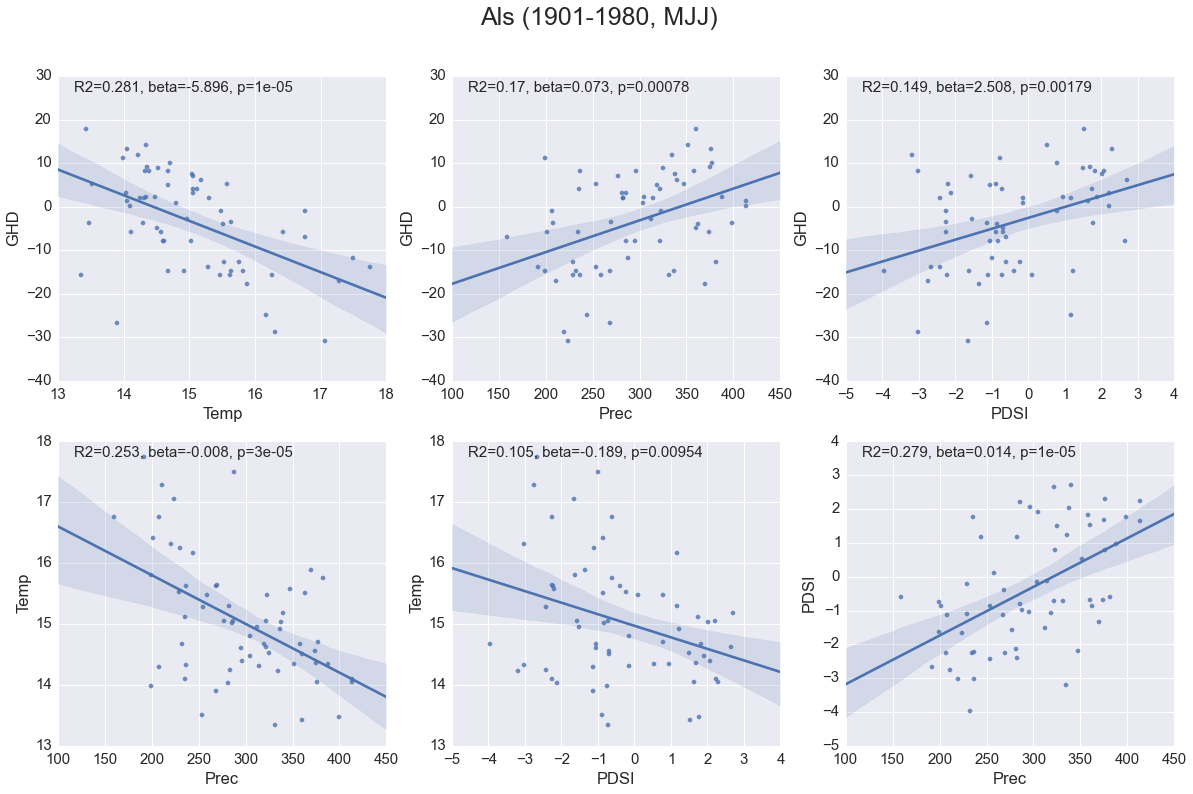

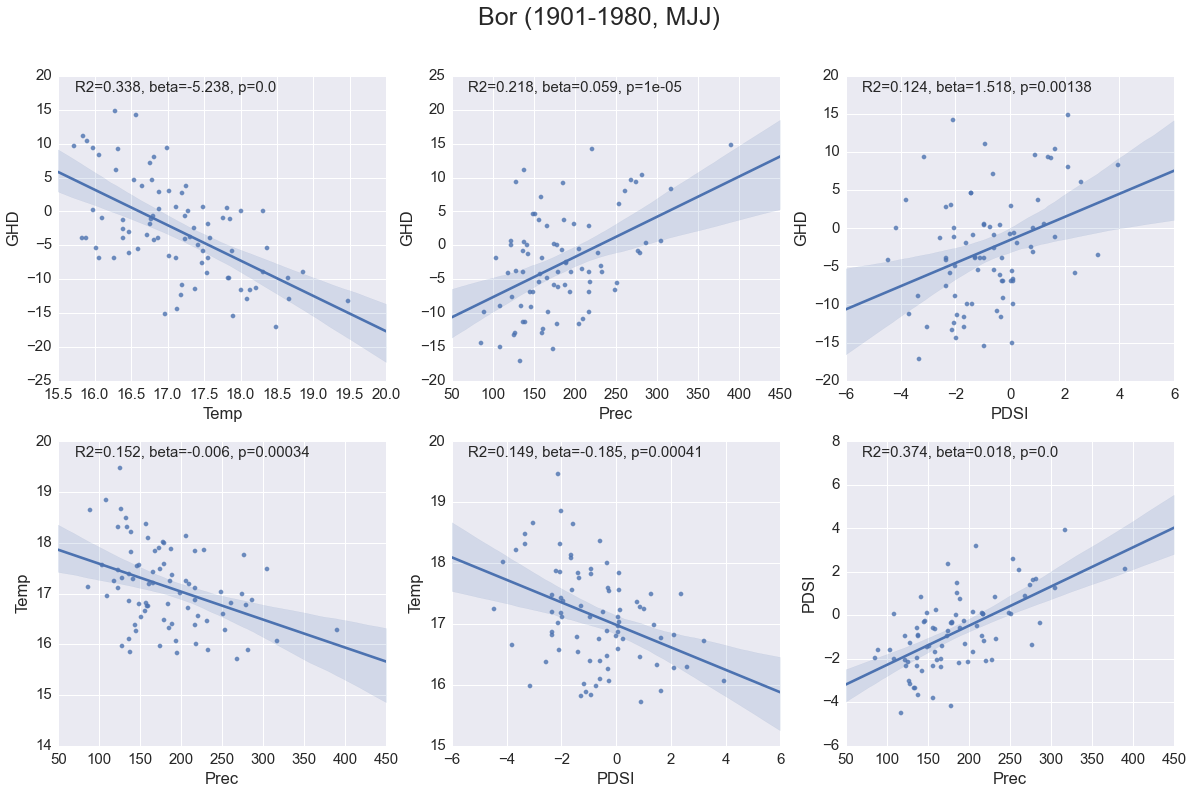

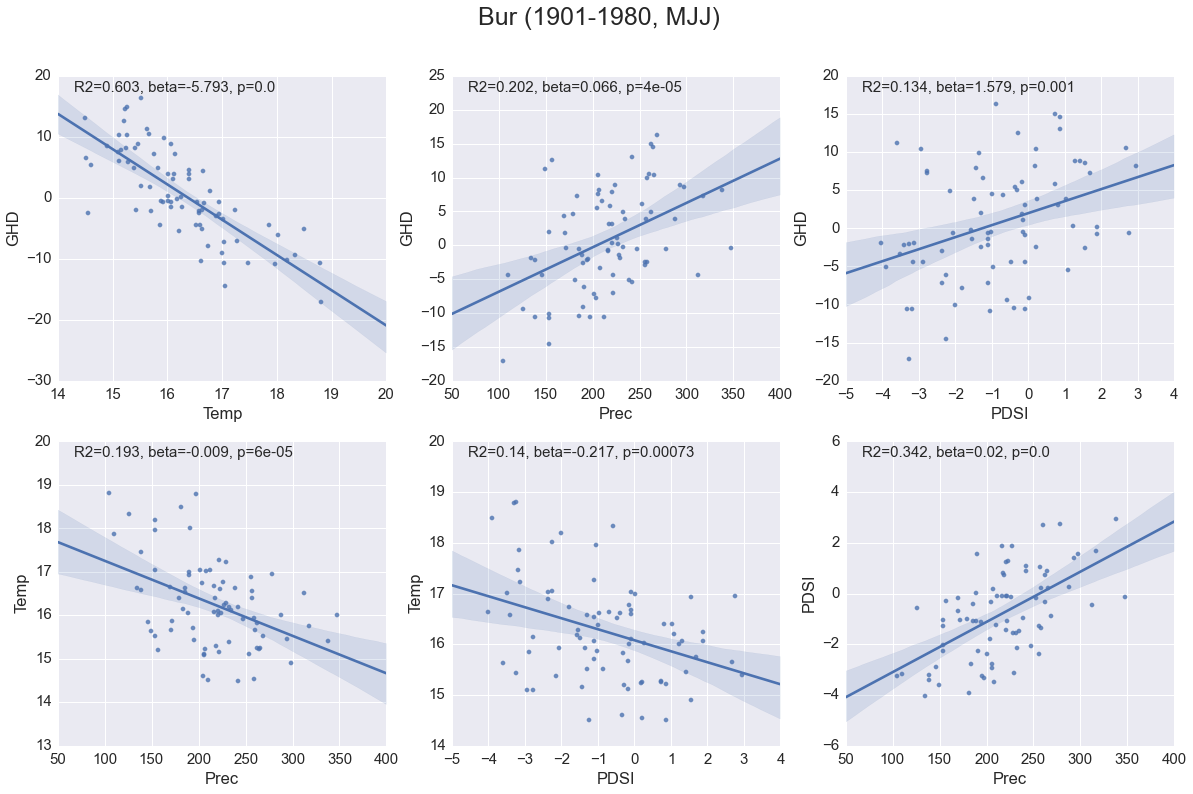

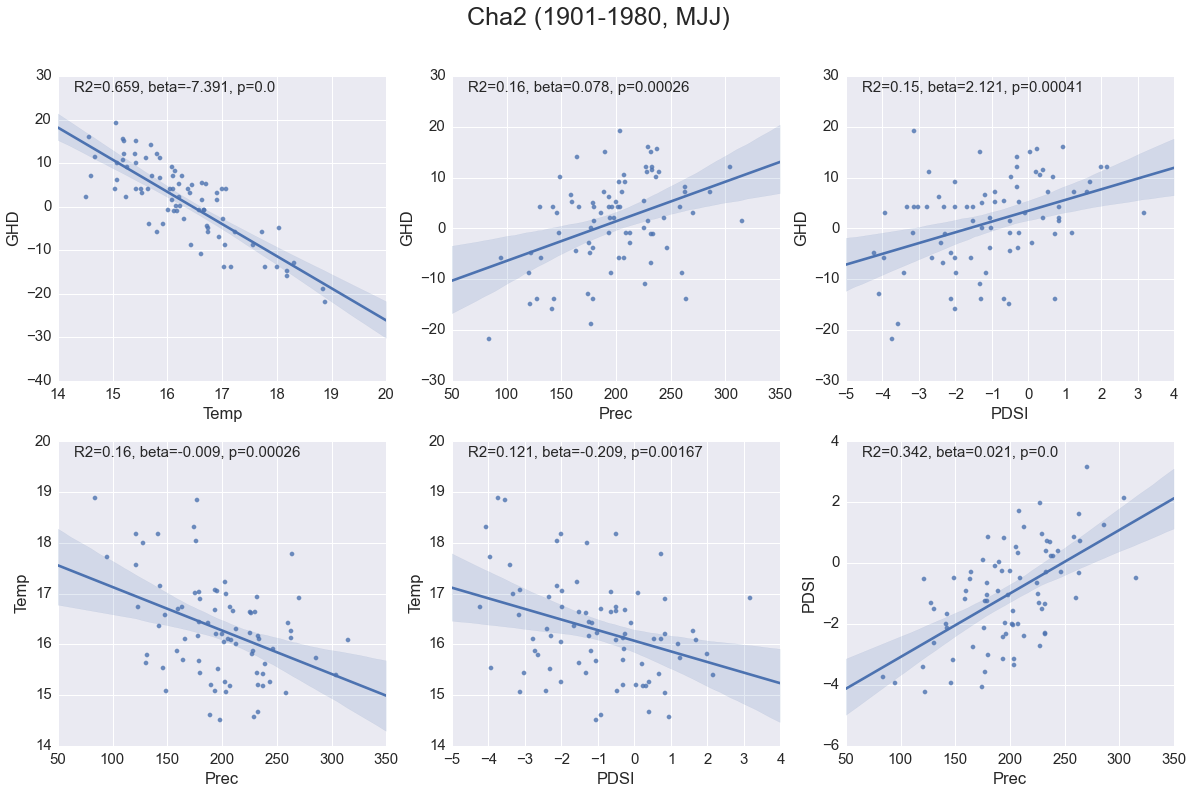

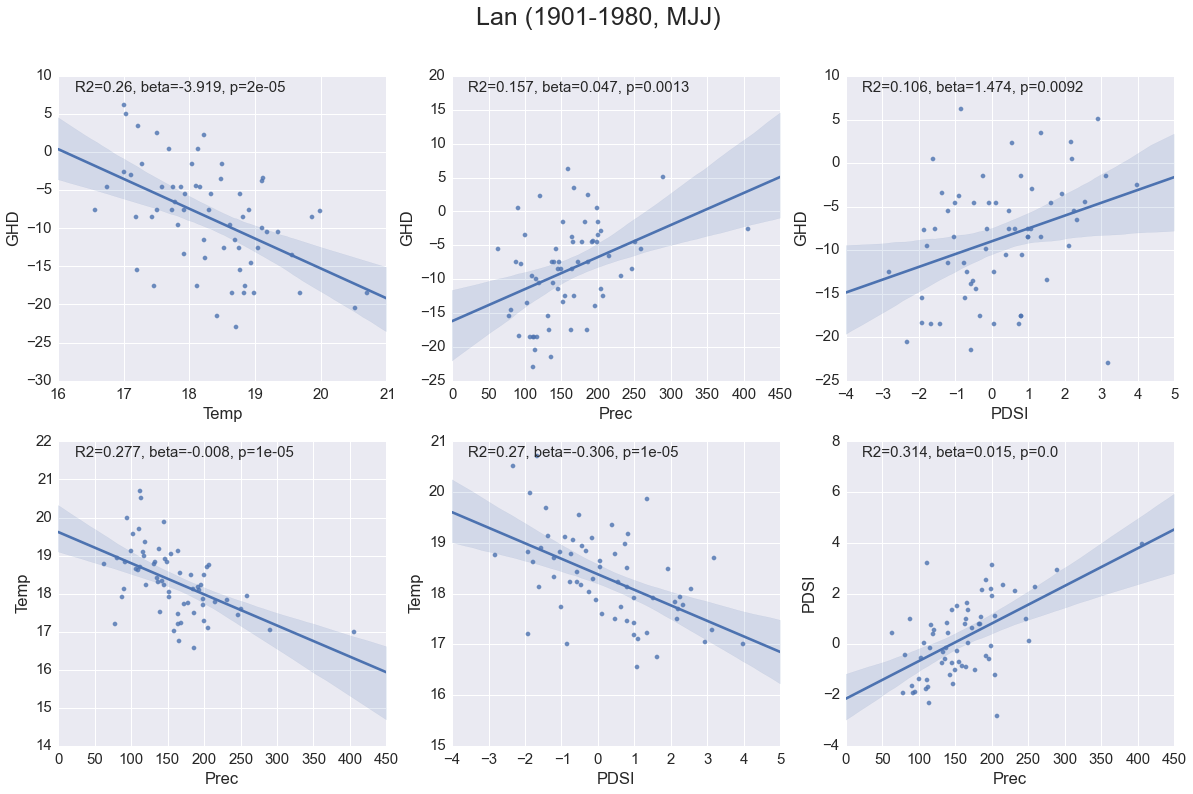

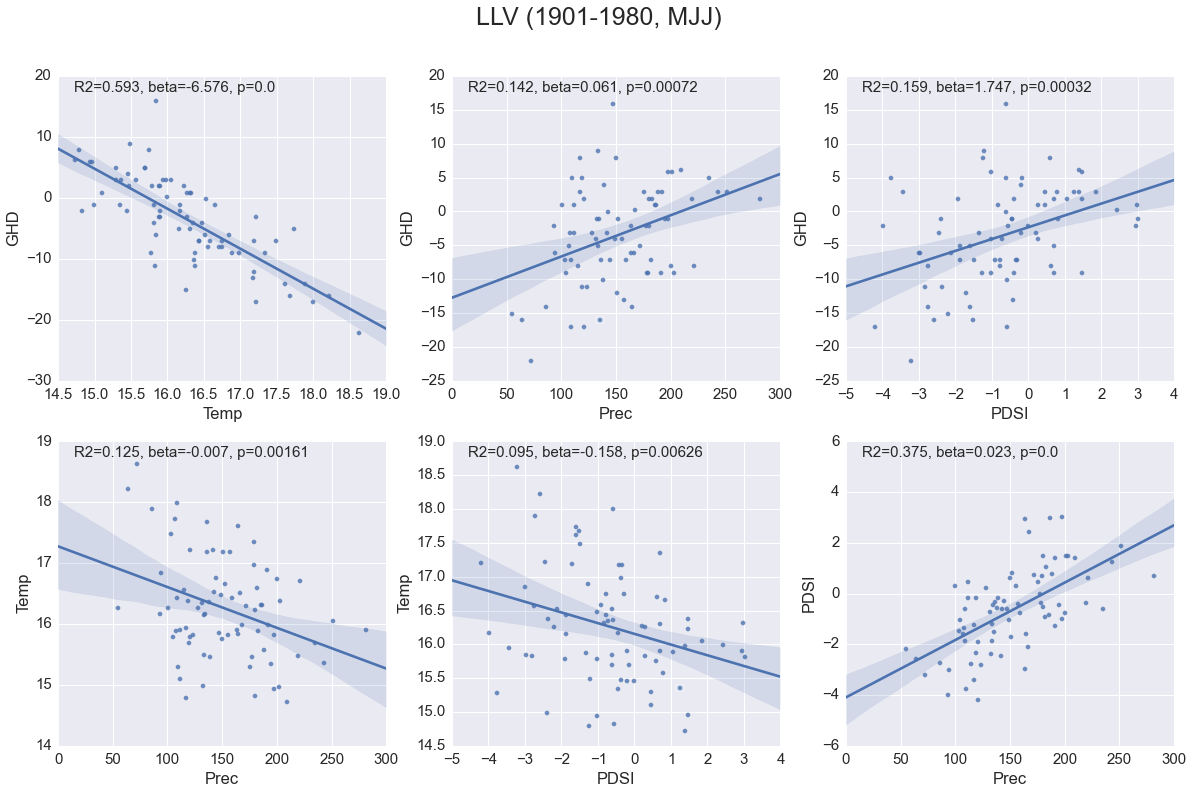

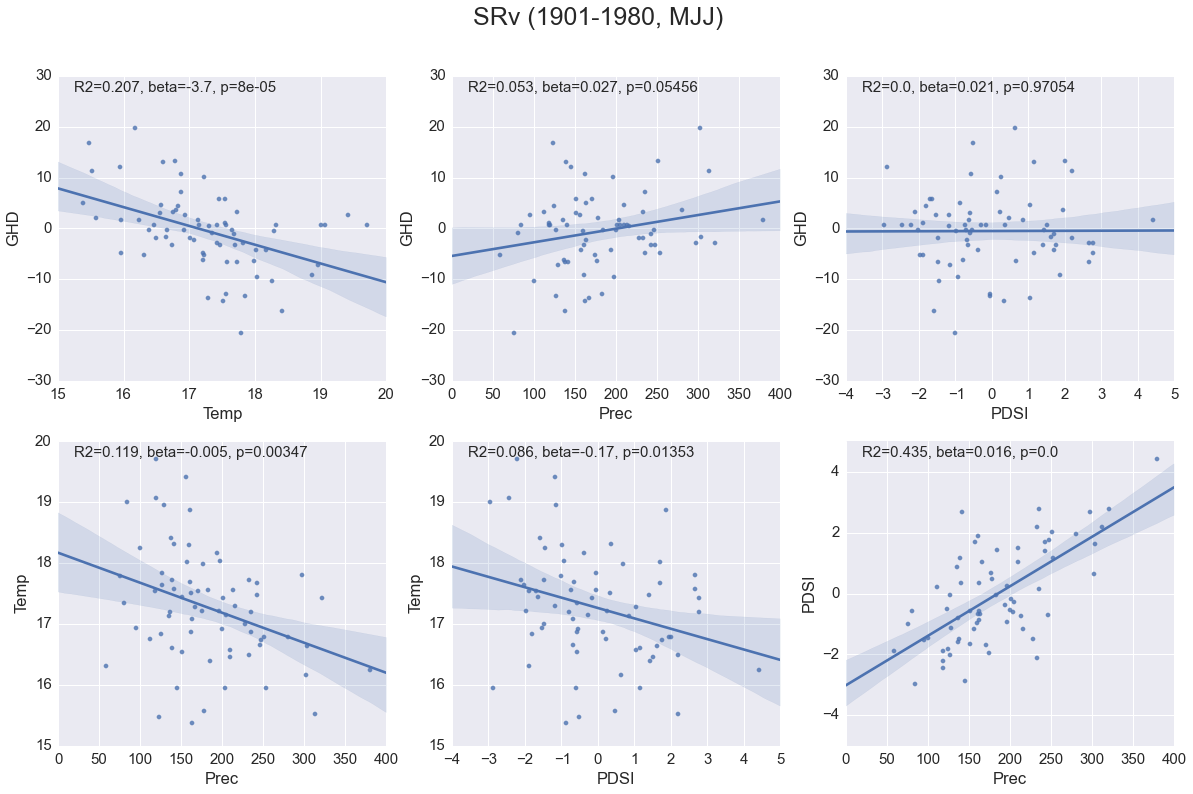

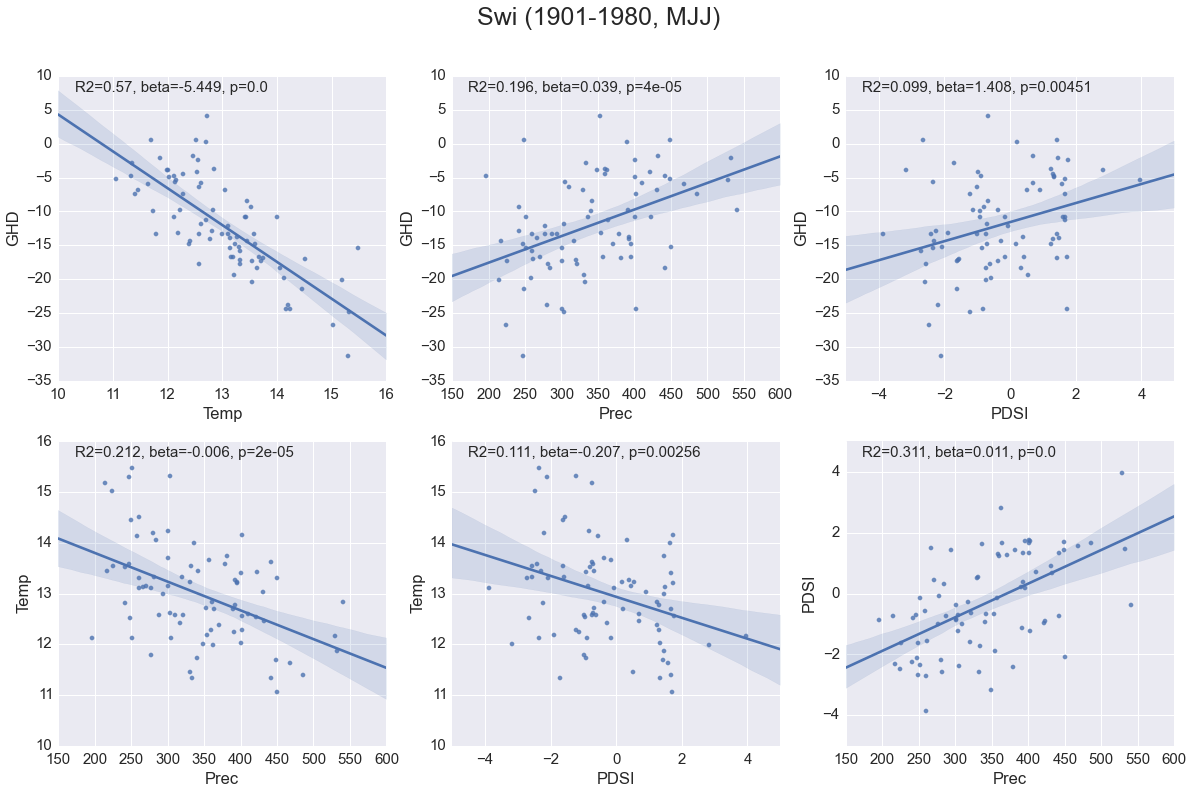

In [17]:
# Regression and scatter plots each GHD Index, INDIVIDUAL SITES ONLY

# Year Locations of the GHD data.
loc_yrs_ghd = np.where((yr>=yr1) & (yr<=yr2))[0];

# Year Locations of the Climate Data.
loc_yrs_cru = np.where((yr_cru>=yr1) & (yr_cru<=yr2))[0];

# Initialize Storage Array for Regression Stats (Slope, R2, pval)
reg_GHDvTemp_site  = np.zeros((8,6))
reg_GHDvPrec_site  = np.zeros((8,6))
reg_GHDvPDSI_site  = np.zeros((8,6))

reg_TempvPrec_site = np.zeros((8,6))
reg_TempvPDSI_site = np.zeros((8,6))
reg_PDSIvPrec_site = np.zeros((8,6))

for ifile in enumerate(ghd_all_names[2:]):

    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]+2]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]+2]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]+2]

    # Create Data Frame
    del df_siteclim
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe
    df_siteclim.GHD =  copy.deepcopy(np.float64(ghd))
    df_siteclim.Temp = copy.deepcopy(np.float64(tmp_series))
    df_siteclim.Prec = copy.deepcopy(np.float64(pre_series))
    df_siteclim.PDSI = copy.deepcopy(np.float64(pdsi_series))
    
    # Remove Missing Values (necessary for regression calculation)
    df_siteclim=df_siteclim[df_siteclim.GHD.notnull()];
    
    # Series Name 
    series_name = ifile[1]

    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,12])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD----------------------------------------------------------------------------------------- 
    sns.plt.subplot(2,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvTemp_site[ifile[0],0] = slope; reg_GHDvTemp_site[ifile[0],2] = R2; reg_GHDvTemp_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Temp),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvTemp_site[ifile[0],1] = slope; reg_GHDvTemp_site[ifile[0],3] = R2; reg_GHDvTemp_site[ifile[0],5] = p_value;
    
    # Subplot #2: Prec vs GHD-----------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
 
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPrec_site[ifile[0],0] = slope; reg_GHDvPrec_site[ifile[0],2] = R2; reg_GHDvPrec_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPrec_site[ifile[0],1] = slope; reg_GHDvPrec_site[ifile[0],3] = R2; reg_GHDvPrec_site[ifile[0],5] = p_value;

    # Subplot #3: PDSI vs GHD-----------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPDSI_site[ifile[0],0] = slope; reg_GHDvPDSI_site[ifile[0],2] = R2; reg_GHDvPDSI_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPDSI_site[ifile[0],1] = slope; reg_GHDvPDSI_site[ifile[0],3] = R2; reg_GHDvPDSI_site[ifile[0],5] = p_value;
    
    # Subplot #4: Prec vs Temp-----------------------------------------------------------------------------------------
    sns.plt.subplot(2,3,4),sns.regplot("Prec","Temp",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.Temp)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)     

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_TempvPrec_site[ifile[0],0] = slope; reg_TempvPrec_site[ifile[0],2] = R2; reg_TempvPrec_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.Temp))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_TempvPrec_site[ifile[0],1] = slope; reg_TempvPrec_site[ifile[0],3] = R2; reg_TempvPrec_site[ifile[0],5] = p_value;
    
    # Subplot #5: PDSI vs Temp-----------------------------------------------------------------------------------------
    sns.plt.subplot(2,3,5),sns.regplot("PDSI","Temp",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.Temp)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)        

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_TempvPDSI_site[ifile[0],0] = slope; reg_TempvPDSI_site[ifile[0],2] = R2; reg_TempvPDSI_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.Temp))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_TempvPDSI_site[ifile[0],1] = slope; reg_TempvPDSI_site[ifile[0],3] = R2; reg_TempvPDSI_site[ifile[0],5] = p_value;
        
    # Subplot #6: PDSI vs Prec----------------------------------------------------------------------------------------- 
    sns.plt.subplot(2,3,6),sns.regplot("Prec","PDSI",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.PDSI)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)      

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_PDSIvPrec_site[ifile[0],0] = slope; reg_PDSIvPrec_site[ifile[0],2] = R2; reg_PDSIvPrec_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.PDSI))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_PDSIvPrec_site[ifile[0],1] = slope; reg_PDSIvPrec_site[ifile[0],3] = R2; reg_PDSIvPrec_site[ifile[0],5] = p_value;
            
    sns.plt.tight_layout
    #sns.plt.savefig('../figures/step03/'+series_name+'.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
    #                '-'+np.str(yr2[0])+'.'+range_txt+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator 


* Okay, now we will create some dataframes and look at the regression results for non-detrended and detrended versions of the INDIVIDUAL SITES. In all cases, overall results are really quite similar between the detrended and the non-detrended analyses.

In [18]:
print("Regression Analyses Results: Display the slopes, R2, and pvalues for each of the regressions,")
print("with and without linearly detrending the data first")
print("")

# Create Data Frames of Regression Analyses
index_txt = ["Als","Bor","Bur","Cha1","Lan","LLV","SRv","Swi"]
col_txt=["beta","beta-D","R2","R2-D","pval","pval-D"]

# GHD versus Temperature
df_reg_GHDvTemp_site = pd.DataFrame(reg_GHDvTemp_site, index=index_txt, \
                               columns=col_txt)
print("GHD vs Temperature: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_GHDvTemp_site)

# GHD versus Precipitation
df_reg_GHDvPrec_site = pd.DataFrame(reg_GHDvPrec_site, index=index_txt, \
                               columns=col_txt)
print("GHD vs Precipitation: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_GHDvPrec_site) 

# GHD versus PDSI
df_reg_GHDvPDSI_site = pd.DataFrame(reg_GHDvPDSI_site, index=index_txt, \
                               columns=col_txt)
print("GHD vs PDSI: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_GHDvPDSI_site) 

# Temp versus Prec
df_reg_TempvPrec_site = pd.DataFrame(reg_TempvPrec_site, index=index_txt, \
                               columns=col_txt)
print("Temp vs Prec: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_TempvPrec_site) 

# Temp versus PDSI
df_reg_TempvPDSI_site = pd.DataFrame(reg_TempvPDSI_site, index=index_txt, \
                               columns=col_txt)
print("Temp vs PDSI: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_TempvPDSI_site) 

# PDSI vs Prec
df_reg_PDSIvPrec_site = pd.DataFrame(reg_PDSIvPrec_site, index=index_txt, \
                               columns=col_txt)
print("PDSI vs Prec: "+np.str(yr1[0])+"-"+np.str(yr2[0]))
display(df_reg_PDSIvPrec_site) 


Regression Analyses Results: Display the slopes, R2, and pvalues for each of the regressions,
with and without linearly detrending the data first

GHD vs Temperature: 1901-1980


beta    beta-D     R2   R2-D          pval        pval-D
Als  -5.895689 -6.321067  0.281  0.471  7.916313e-06  5.324353e-10
Bor  -5.237765 -6.052227  0.338  0.541  1.578445e-08  7.589371e-15
Bur  -5.792567 -5.876746  0.603  0.634  6.634010e-17  2.947484e-18
Cha1 -7.391046 -7.401767  0.659  0.677  1.157992e-19  1.431790e-20
Lan  -3.918993 -4.717313  0.260  0.500  1.960947e-05  9.520843e-11
LLV  -6.576498 -6.696983  0.593  0.601  2.780978e-16  1.306116e-16
SRv  -3.700407 -3.447531  0.207  0.180  7.739899e-05  2.549475e-04
Swi  -5.449466 -5.474080  0.570  0.572  5.793101e-16  4.773105e-16

GHD vs Precipitation: 1901-1980


beta    beta-D     R2   R2-D      pval        pval-D
Als   0.073000  0.064292  0.170  0.192  0.000781  3.329483e-04
Bor   0.059422  0.063050  0.218  0.302  0.000013  1.322445e-07
Bur   0.065608  0.065795  0.202  0.208  0.000037  2.732903e-05
Cha1  0.078060  0.078883  0.160  0.167  0.000259  1.818792e-04
Lan   0.047397  0.039739  0.157  0.148  0.001303  1.861375e-03
LLV   0.060993  0.061075  0.142  0.142  0.000723  7.437650e-04
SRv   0.026886  0.028241  0.053  0.062  0.054557  3.764194e-02
Swi   0.039317  0.039325  0.196  0.196  0.000039  3.875109e-05

GHD vs PDSI: 1901-1980


beta    beta-D     R2   R2-D      pval    pval-D
Als   2.507959  1.887754  0.149  0.119  0.001794  0.005593
Bor   1.518307  1.452033  0.124  0.139  0.001375  0.000644
Bur   1.578584  1.549649  0.134  0.132  0.000998  0.001095
Cha1  2.120948  2.125396  0.150  0.155  0.000415  0.000337
Lan   1.473681  1.871881  0.106  0.228  0.009199  0.000076
LLV   1.746623  1.749189  0.159  0.160  0.000323  0.000314
SRv   0.021214  0.111347  0.000  0.001  0.970543  0.842527
Swi   1.408491  1.419087  0.099  0.100  0.004512  0.004310

Temp vs Prec: 1901-1980


beta    beta-D     R2   R2-D      pval    pval-D
Als  -0.008001 -0.008166  0.253  0.262  0.000027  0.000018
Bor  -0.005514 -0.005391  0.152  0.149  0.000344  0.000401
Bur  -0.008614 -0.008606  0.193  0.194  0.000056  0.000055
Cha1 -0.008562 -0.008564  0.160  0.160  0.000264  0.000264
Lan  -0.008191 -0.008706  0.277  0.316  0.000009  0.000002
LLV  -0.006696 -0.006493  0.125  0.119  0.001605  0.002075
SRv  -0.004932 -0.005099  0.119  0.134  0.003474  0.001858
Swi  -0.005668 -0.005675  0.212  0.214  0.000017  0.000016

Temp vs PDSI: 1901-1980


beta    beta-D     R2   R2-D      pval    pval-D
Als  -0.189492 -0.203637  0.105  0.118  0.009536  0.005934
Bor  -0.184611 -0.187731  0.149  0.158  0.000414  0.000264
Bur  -0.216681 -0.218781  0.140  0.143  0.000735  0.000642
Cha1 -0.209073 -0.209055  0.121  0.121  0.001673  0.001674
Lan  -0.306147 -0.298030  0.270  0.257  0.000013  0.000022
LLV  -0.158241 -0.159636  0.095  0.099  0.006258  0.005217
SRv  -0.170387 -0.182338  0.086  0.104  0.013526  0.006570
Swi  -0.206664 -0.211118  0.111  0.116  0.002556  0.002030

PDSI vs Prec: 1901-1980


beta    beta-D     R2   R2-D          pval        pval-D
Als   0.014378  0.014025  0.279  0.273  8.620476e-06  1.132703e-05
Bor   0.018030  0.018164  0.374  0.378  1.700643e-09  1.265676e-09
Bur   0.019785  0.019799  0.342  0.343  1.886332e-08  1.747893e-08
Cha1  0.020862  0.020871  0.342  0.342  1.511106e-08  1.504043e-08
Lan   0.014821  0.015655  0.314  0.352  1.751671e-06  2.917564e-07
LLV   0.022637  0.022866  0.375  0.380  3.263444e-09  2.424011e-09
SRv   0.016268  0.016209  0.435  0.433  5.487093e-10  5.922151e-10
Swi   0.011043  0.011033  0.311  0.312  7.898300e-08  7.420165e-08

# Spatial, point by point correlations between each GHD time series and the climate data
* For these analyses, I will conduct the point by point correlation analyses on the data WITH and WITHOUT linear trends.

In [19]:
# Find Years I want to conduct correlations over.

# Year Locations of the GHD data.
loc_yrs_ghd = np.where((yr>=yr1) & (yr<=yr2))[0];

# Year Locations of the Climate Data.
loc_yrs_cru = np.where((yr_cru>=yr1) & (yr_cru<=yr2))[0];

# Initialize Matrices for Correlation Results
#
# NON-DETRENDED
rho_ghd_pdsi  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_pdsi[:]=np.NAN
rho_ghd_temp  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_temp[:]=np.NAN
rho_ghd_prec  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_prec[:]=np.NAN
# DETRENDED
rho_ghd_pdsi_det = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_pdsi[:]=np.NAN
rho_ghd_temp_det = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_temp[:]=np.NAN
rho_ghd_prec_det = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_prec[:]=np.NAN

# Pull Out All The Sites Names
site_names = df_sitelocs.Location

# Loop through each GHD site individually-------------------------------------------------------------------------------------
for ifile in enumerate(ghd_all_names):
    # Counter
    print(ifile)
    
    # Pull out Current GHD Series for This Site
    ghd_mean = np.float64(df[ifile[1]]);  
    
    # Trim Years to the time period I want to investigate
    ghd_mean = ghd_mean[loc_yrs_ghd];     
    
    # index for real values (not missing)
    realvals = np.where(~np.isnan(ghd_mean))[0]
    
    # GHD Data for Current Site (with and without trend)
    ghd_trend = ghd_mean[realvals]
    ghd_detrend  = scipy.signal.detrend(ghd_mean[realvals])
       
# Loop through each gridcell of climate data and calculate the correlations---------------------------------------------------
    for n_lat in enumerate(i_lat):
        for n_lon in enumerate(i_lon):
    
            # Pull out Individual gridcell pdsi/temp/prec
            pdsi_seas_cell = pdsi_seas[loc_yrs_cru,n_lat[0],n_lon[0]]
            temp_seas_cell = tmp_seas_ave[loc_yrs_cru,n_lat[0],n_lon[0]]
            prec_seas_cell = pre_seas_sum[loc_yrs_cru,n_lat[0],n_lon[0]]
            
            # Linearly Detrend Prior to Correlation
            # Climate Data Data for Current Site (with and without trend)
            pdsi_cell_trend = pdsi_seas_cell[realvals]
            tmp_cell_trend  = temp_seas_cell[realvals]
            pre_cell_trend  = prec_seas_cell[realvals]
            
            pdsi_cell_detrend = scipy.signal.detrend(pdsi_seas_cell[realvals])
            tmp_cell_detrend  = scipy.signal.detrend(temp_seas_cell[realvals])
            pre_cell_detrend  = scipy.signal.detrend(prec_seas_cell[realvals])

            # Put in NaN if ocean areas (missing values)
            if temp_seas_cell[0]>1000:
                    
                rho_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]]     = np.nan
                rho_ghd_pdsi_det[ifile[0],n_lat[0],n_lon[0]] = np.nan
       
                rho_ghd_temp[ifile[0],n_lat[0],n_lon[0]]     = np.nan
                rho_ghd_temp_det[ifile[0],n_lat[0],n_lon[0]] = np.nan

                rho_ghd_prec[ifile[0],n_lat[0],n_lon[0]]     = np.nan
                rho_ghd_prec_det[ifile[0],n_lat[0],n_lon[0]] = np.nan
            
            # Otherwise, calculate the correlations
            else:   
            
                # Spearman rank correlations: PDSI
                rho,pval = stats.spearmanr(pdsi_cell_trend,ghd_trend)    
                rho_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]]      = rho
                
                rho,pval = stats.spearmanr(pdsi_cell_detrend,ghd_detrend)    
                rho_ghd_pdsi_det[ifile[0],n_lat[0],n_lon[0]]  = rho
                 
                # Spearman rank correlations: Temp
                rho,pval = stats.spearmanr(tmp_cell_trend,ghd_trend)    
                rho_ghd_temp[ifile[0],n_lat[0],n_lon[0]]      = rho
                
                rho,pval = stats.spearmanr(tmp_cell_detrend,ghd_detrend)    
                rho_ghd_temp_det[ifile[0],n_lat[0],n_lon[0]]  = rho
        
                # Spearman rank correlations: Prec
                rho,pval = stats.spearmanr(pre_cell_trend,ghd_trend)    
                rho_ghd_prec[ifile[0],n_lat[0],n_lon[0]]  = rho
                
                rho,pval = stats.spearmanr(pre_cell_detrend,ghd_detrend)    
                rho_ghd_prec_det[ifile[0],n_lat[0],n_lon[0]]  = rho
   
                # More missing gridcells from PDSI Dataset
                if pdsi_seas_cell[0]>1000:
                    rho_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                    rho_ghd_pdsi_det[ifile[0],n_lat[0],n_lon[0]]  = np.nan


(0, 'GHDmean')
(1, 'GHDcore')
(2, 'Als')
(3, 'Bor')
(4, 'Bur')
(5, 'Cha2')
(6, 'Lan')
(7, 'LLV')
(8, 'SRv')
(9, 'Swi')


* Set the Map Parameters

In [21]:
# Mapping Parameters
# Set Map Limits and coordinates for mapping
lon_map = lon[i_lon]; lat_map = lat[i_lat];

lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
lon_map, lat_map = np.meshgrid(lon_map, lat_map)

site_color = np.float64([0,0,0])/255

# Title info
fontdict = {'fontsize': 18}

# Set Row and Column Size based on number of Points I'm Correlating
if np.size(ghd_all_names)<=9:
    numrow=3
    numcol=3
    figdims=20
elif np.size(ghd_all_names)>=10:
    numrow=4
    numcol=3
    figdims=30

* First, plot the TEMPERATURE correlations calculated from the data including trends.

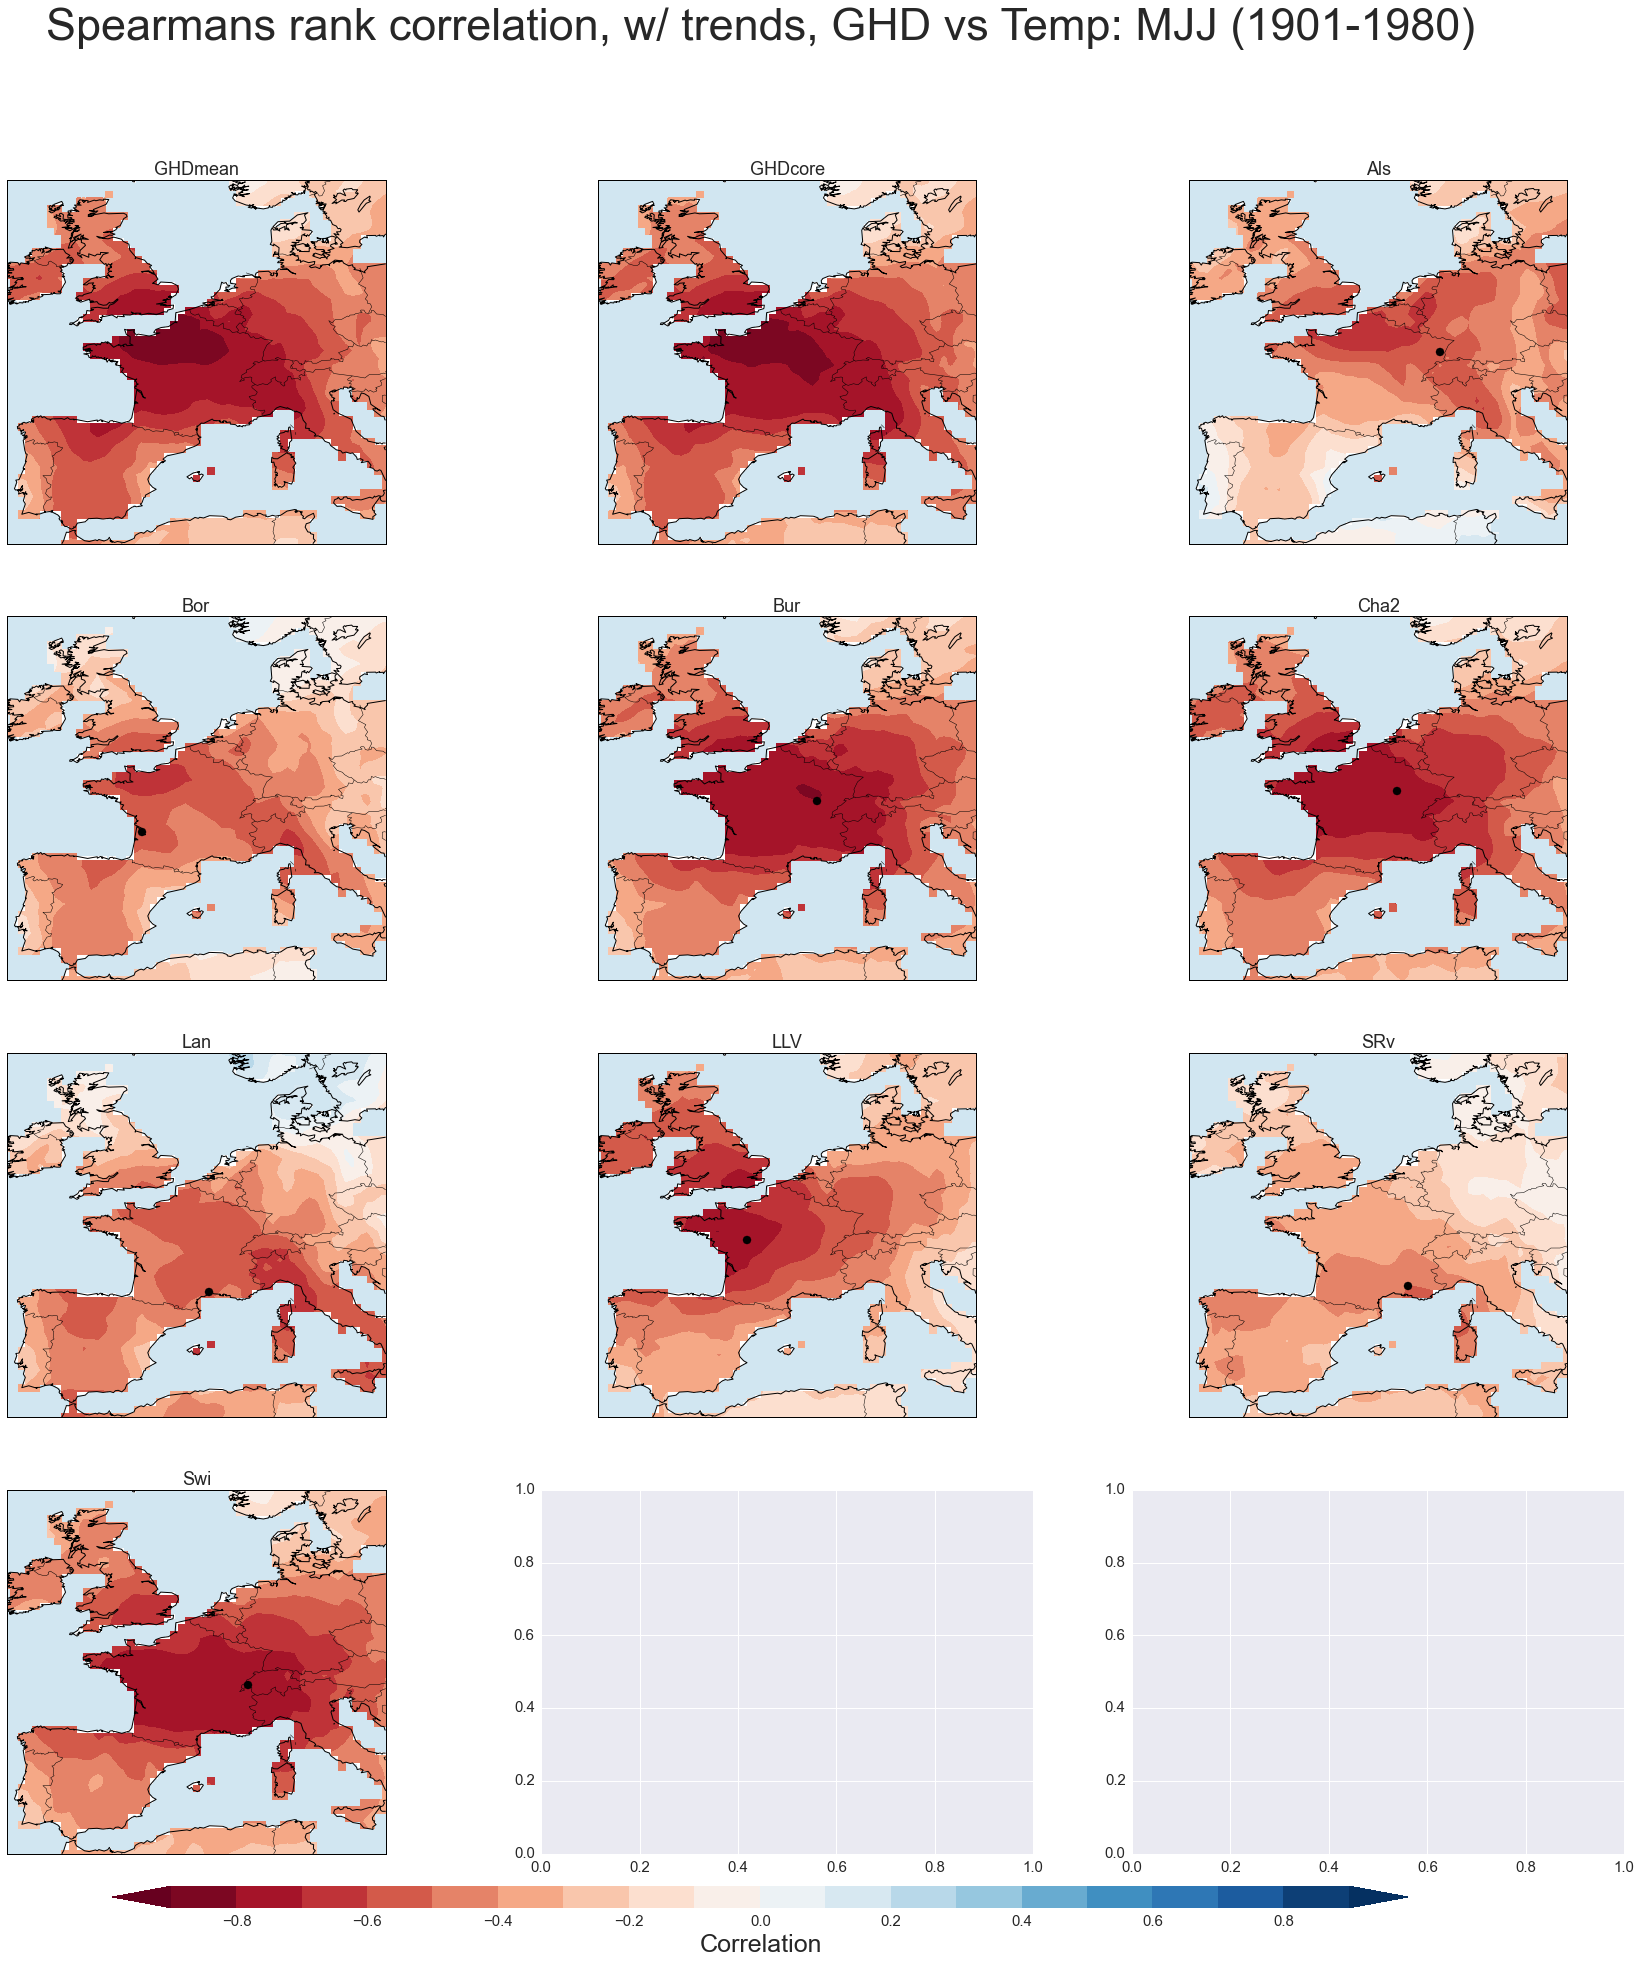

In [22]:
# Temp Correlations: Super Figure, All Sites
# (1) SETUP FIGURE
title_txt = 'Spearman''s rank correlation, w/ trends, GHD vs Temp: '+mons_ave_txt+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_temp[ifile[0],:,:];
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)

sns.plt.suptitle(title_txt,fontsize=45)
#out_txt = '../figures/step03/corrmap.withtrend.ghd.vs.temp.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator



* Now, plot the TEMPERATURE correlations calculated from the DETRENDED data.

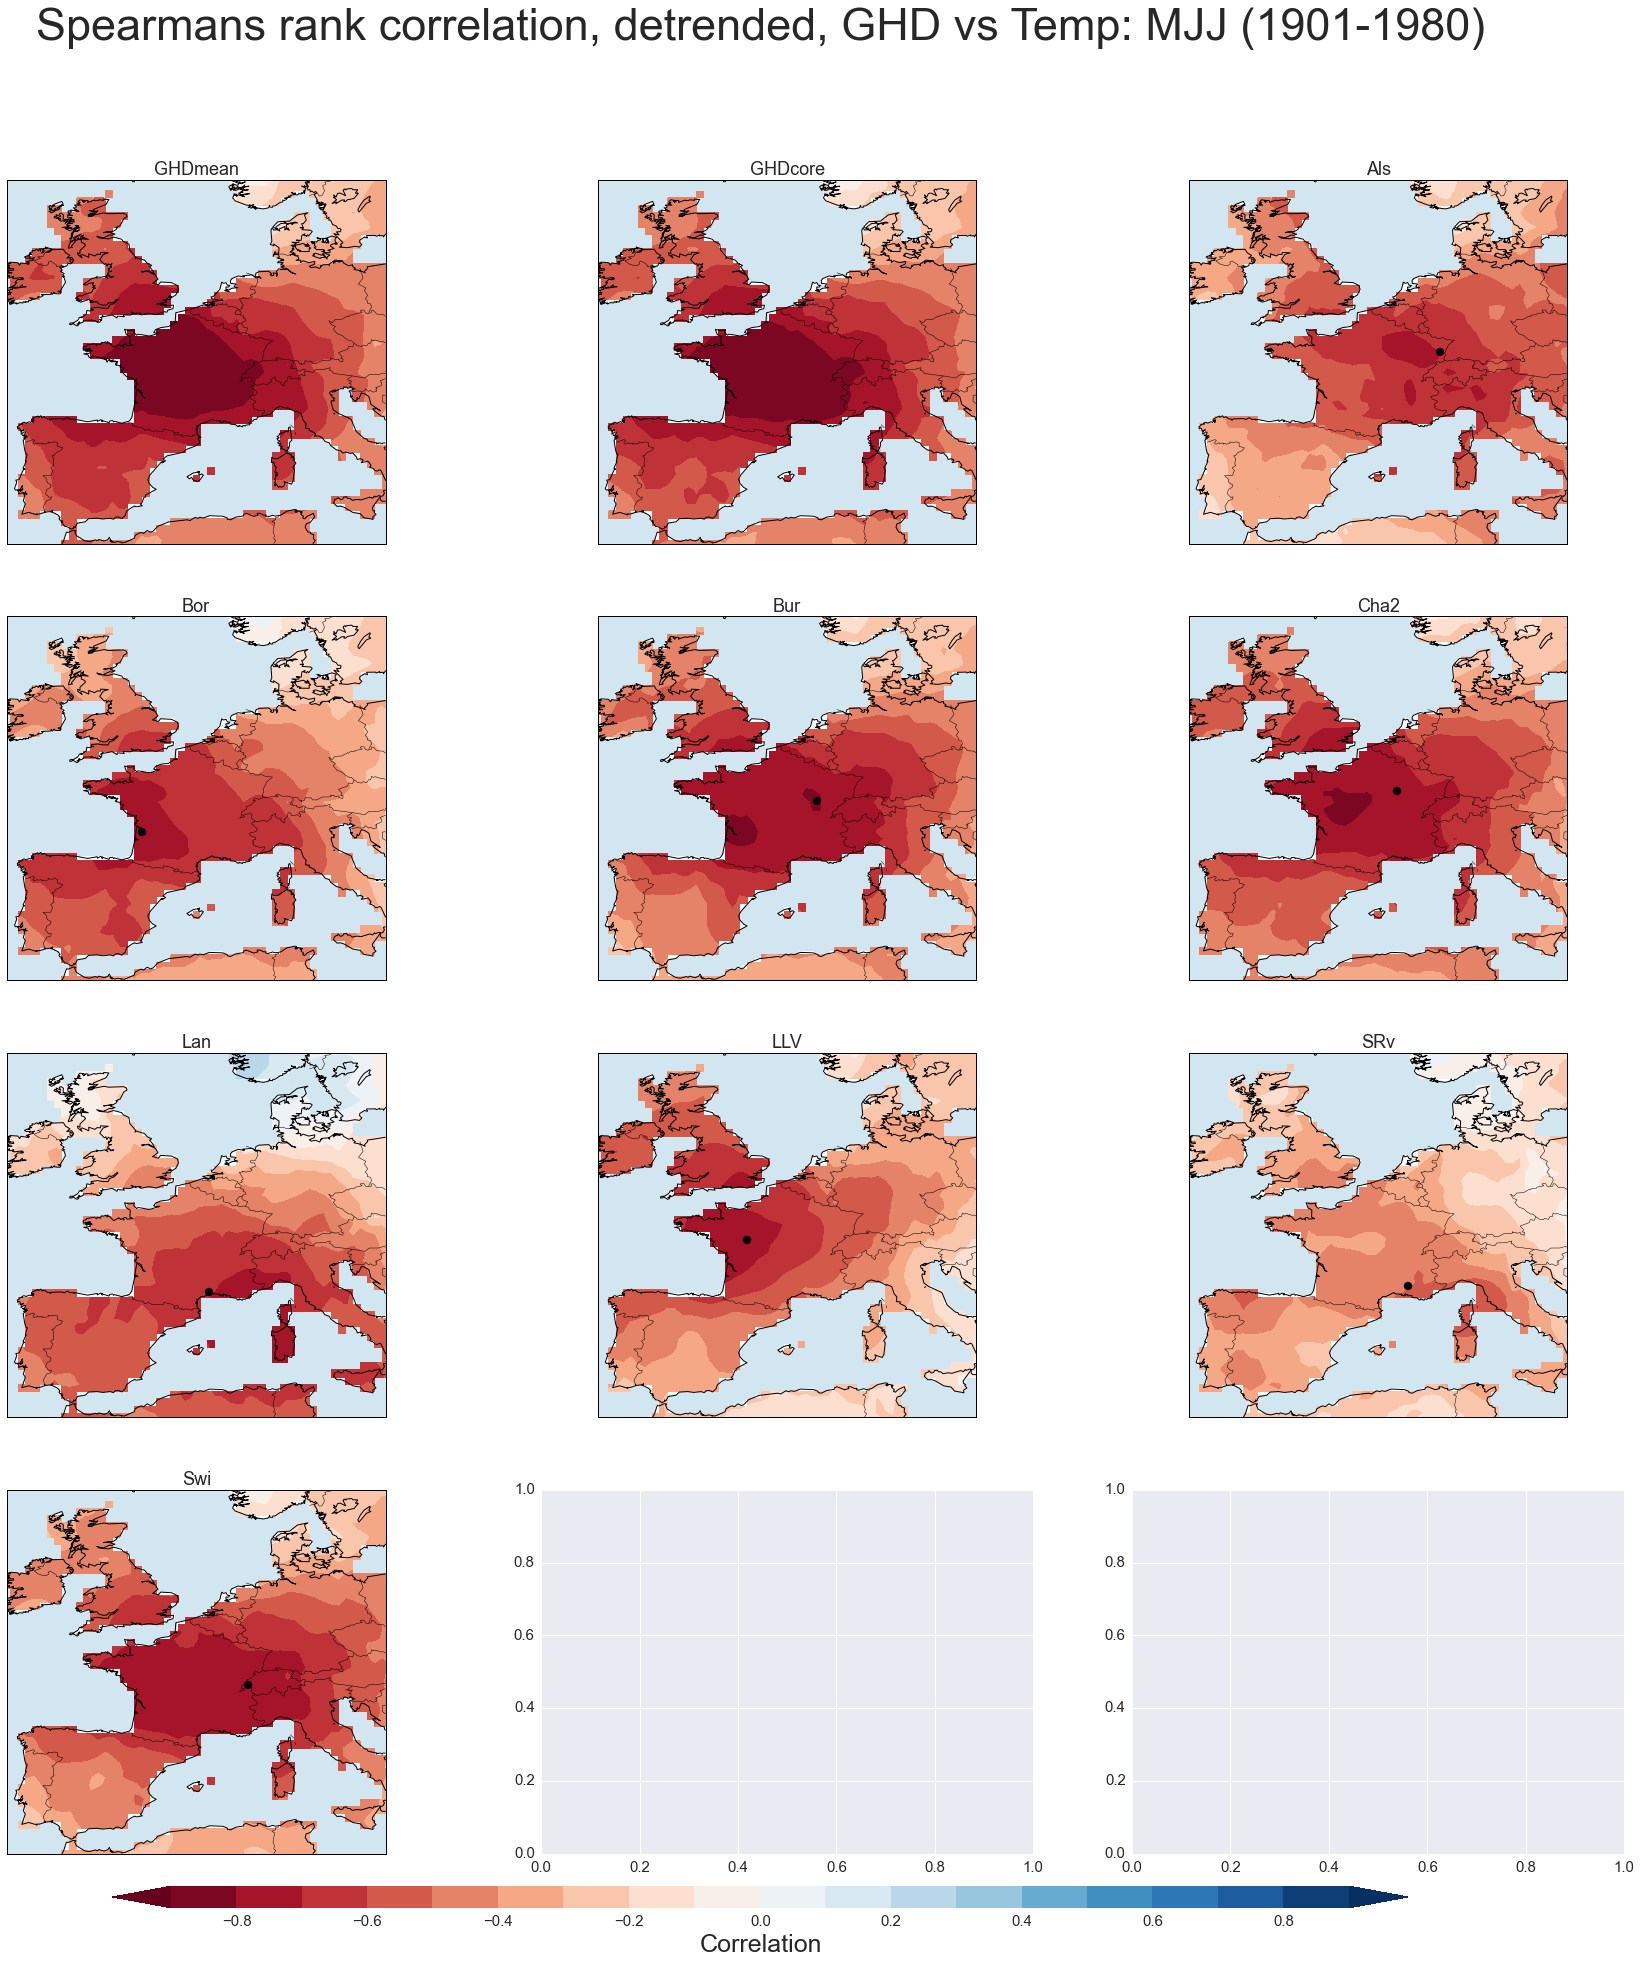

In [23]:
# Temp Correlations: Super Figure, All Sites
# (1) SETUP FIGURE
title_txt = 'Spearman''s rank correlation, detrended, GHD vs Temp: '+mons_ave_txt+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_temp_det[ifile[0],:,:];
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
sns.plt.suptitle(title_txt,fontsize=45)
#out_txt = '../figures/step03/corrmap.detrend.ghd.vs.temp.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator


* Precipitation correlations WITH trends

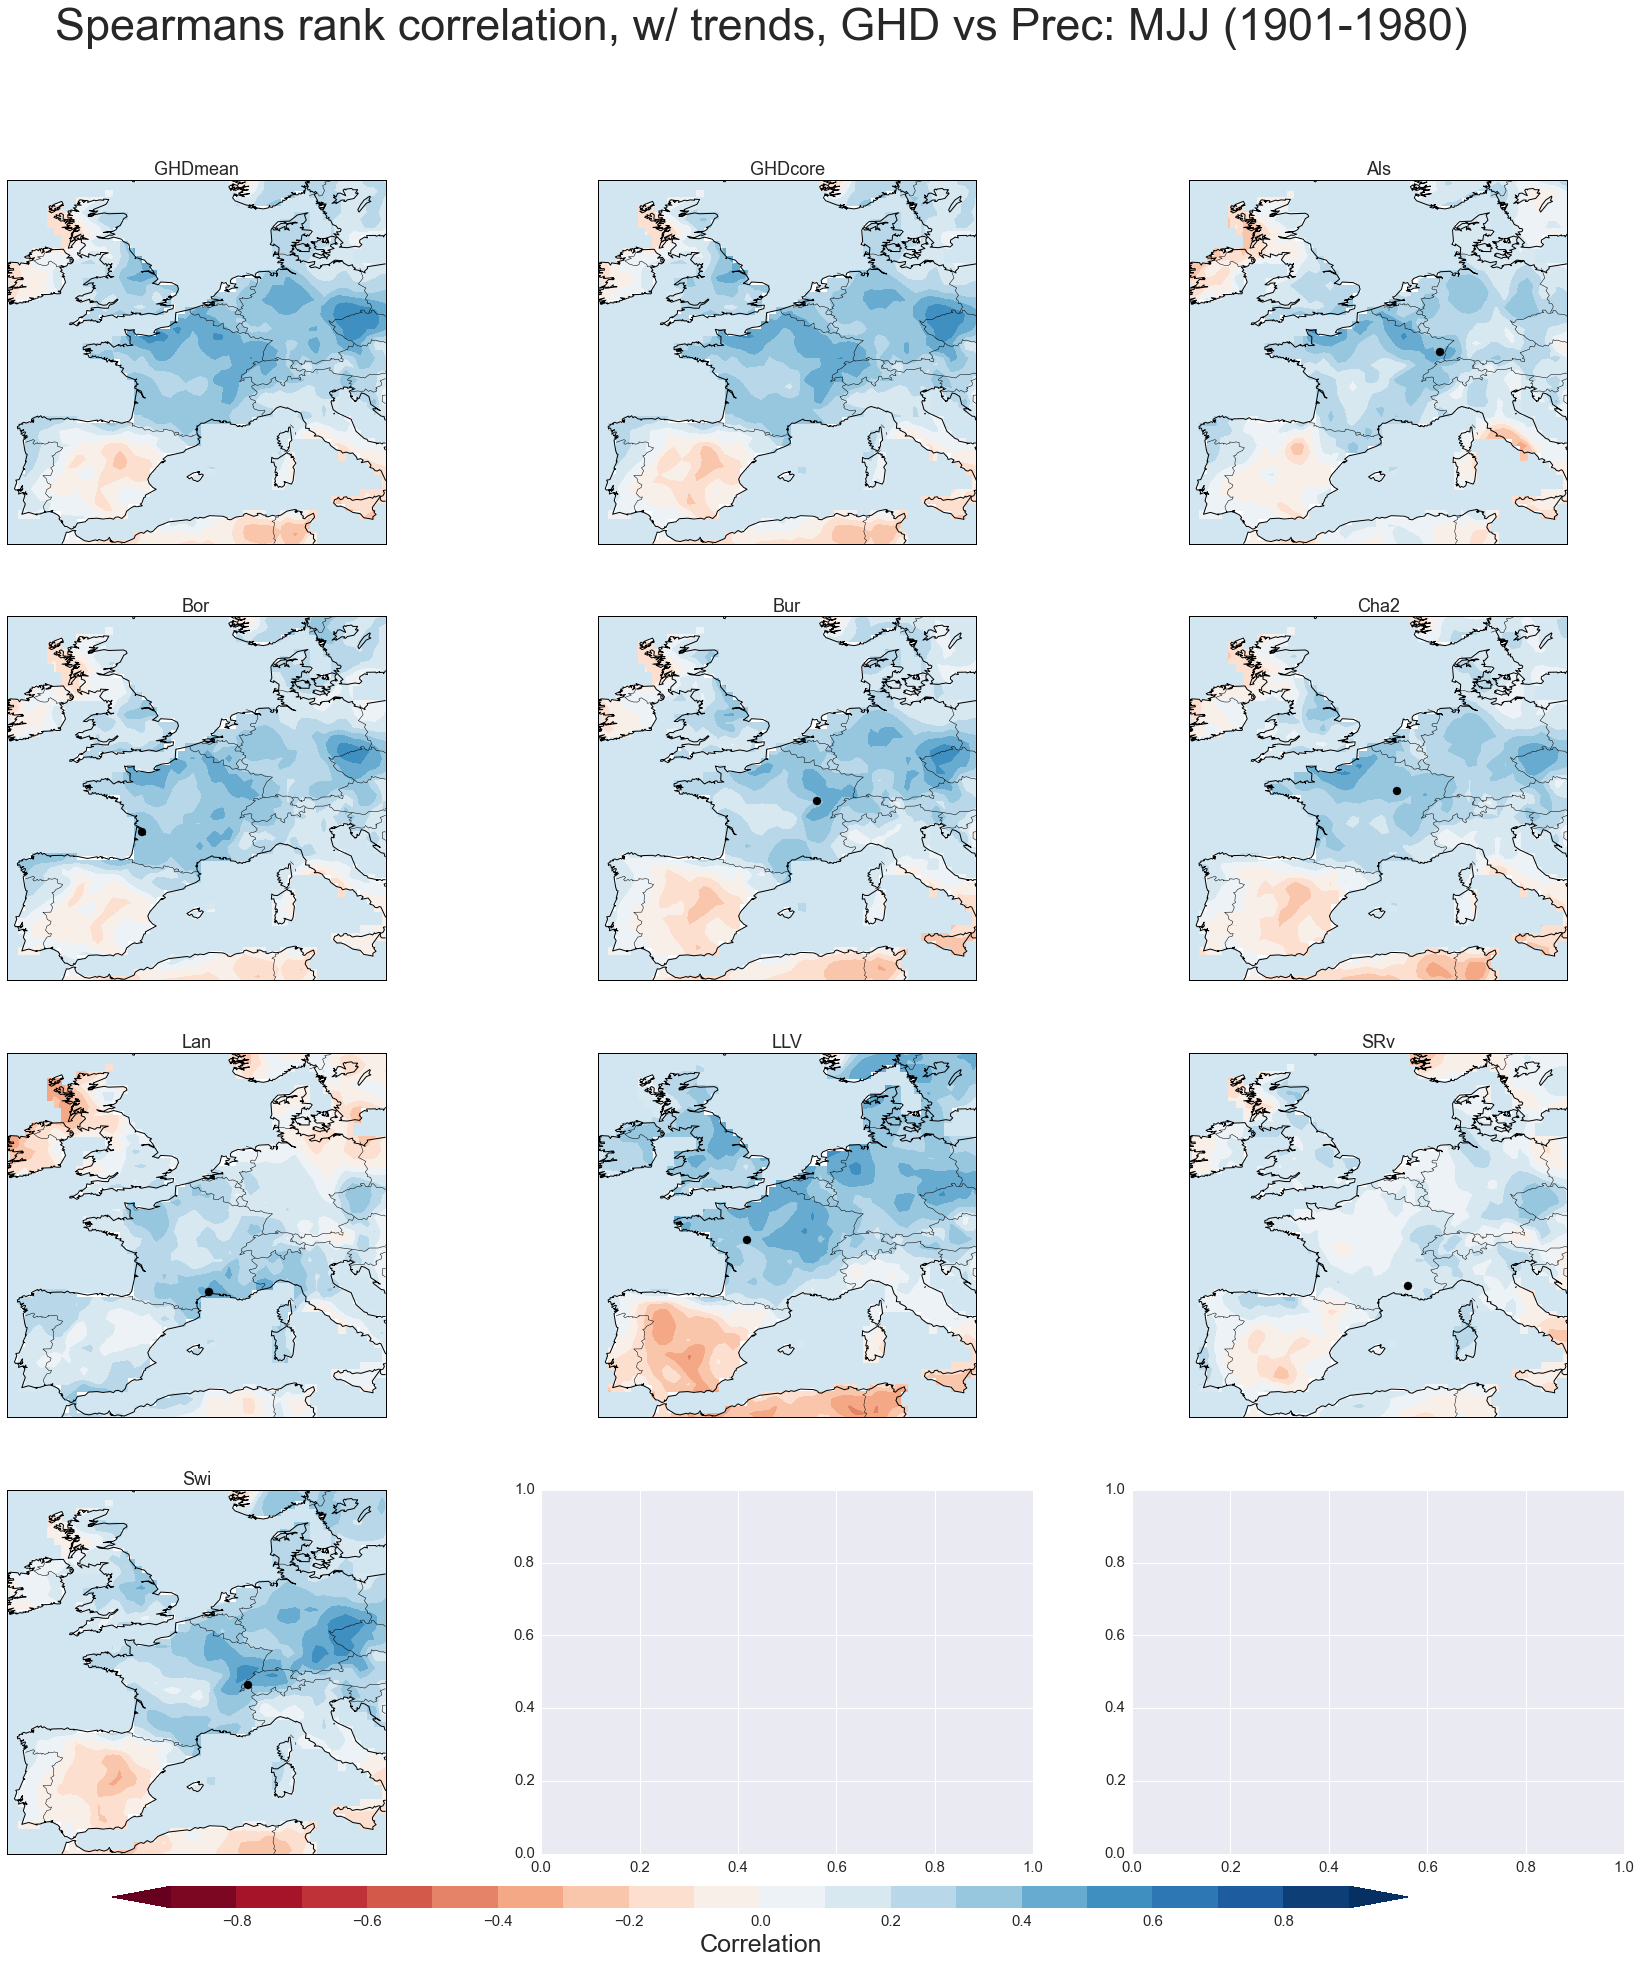

In [24]:
# Prec Correlations: Super Figure, All Sites
# (1) SETUP FIGURE
title_txt = 'Spearman''s rank correlation, w/ trends, GHD vs Prec: '+mons_ave_txt+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_prec[ifile[0],:,:];
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    #plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
sns.plt.suptitle(title_txt,fontsize=45)
out_txt = '../figures/step03/corrmap.withtrend.ghd.vs.prec.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator


* Precipitation correlations on DETRENDED data

In [ ]:
# Temp Correlations: Super Figure, All Sites
# (1) SETUP FIGURE
title_txt = 'Spearman''s rank correlation, detrended, GHD vs Prec: '+mons_ave_txt+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_prec_det[ifile[0],:,:];
                
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
sns.plt.suptitle(title_txt,fontsize=45)
out_txt = '../figures/step03/corrmap.detrend.ghd.vs.prec.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

* PDSI correlations WITH trends

In [ ]:
# PDSI Correlations: Super Figure, All Sites
# (1) SETUP FIGURE
title_txt = 'Spearman''s rank correlation, w/ trends, GHD vs PDSI: '+mons_ave_txt+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_pdsi[ifile[0],:,:];
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)
    # (9) SAVE TO OUTPUT
    #plt.show()

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
sns.plt.suptitle(title_txt,fontsize=45)
out_txt = '../figures/step03/corrmap.withtrend.ghd.vs.pdsi.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

* PDSI correlations on DETRENDED data

In [ ]:
# PDSI Correlations: Super Figure, All Sites
# (1) SETUP FIGURE
title_txt = 'Spearman''s rank correlation, detrended, GHD vs PDSI: '+mons_ave_txt+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))

for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_pdsi_det[ifile[0],:,:];
                
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    axcurr.set_title(ifile[1],fontsize=18)

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
sns.plt.suptitle(title_txt,fontsize=45)
out_txt = '../figures/step03/corrmap.detrend.ghd.vs.pdsi.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

* Individual Plots for GHD Core Only (with trends)

In [ ]:
for ifile in enumerate(ghd_all_names[1:2]):
    print(ifile)
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    # TEMPERATURE
    # Pull out current correlation field
    corr_field = rho_ghd_temp[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs Temp, w/trend ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.temp.withtrend.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    #fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

    # PRECIPITATION
    # Pull out current correlation field
    corr_field = rho_ghd_prec[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs Prec, w/trend ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.prec.withtrend.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    #fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

    # PDSI
    # Pull out current correlation field
    corr_field = rho_ghd_pdsi[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs PDSI, w/trend ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.pdsi.withtrend.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    #fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator


* Individual Plots for GHD Core Only (DETREND)

In [ ]:
for ifile in enumerate(ghd_all_names[1:2]):
    print(ifile)
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    # TEMPERATURE
    # Pull out current correlation field
    corr_field = rho_ghd_temp_det[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs Temp, detrend ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.temp.detrend.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    #fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

    # PRECIPITATION
    # Pull out current correlation field
    corr_field = rho_ghd_prec_det[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs Prec, detrend ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.prec.detrend.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    #fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

    # PDSI
    # Pull out current correlation field
    corr_field = rho_ghd_pdsi_det[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs PDSI, detrend ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.pdsi.detrend.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    #fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator



In [ ]:
print("DONE!")
print("Last run: "+str(datetime.datetime.now()))